# Project 4: West Nile Virus Prediction

Notebook 2 of 4

In [1]:
# import sys
# !{sys.executable} -m pip install -U pandas-profiling[notebook]
# !jupyter nbextension enable --py widgetsnbextension

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import matplotlib.ticker as ticker
import pandas_profiling
from sklearn.neighbors import KernelDensity

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# EDA

In [3]:
# Load datasets
train = pd.read_csv('./datasets/cleaned_train.csv')
test = pd.read_csv('./datasets/cleaned_test.csv')
weather = pd.read_csv('./datasets/cleaned_weather.csv')
spray = pd.read_csv('./datasets/cleaned_spray.csv')

In [4]:
merged_df = pd.merge(weather, train, on=['Date', 'Year', 'Week', 'Month', 'DayOfWeek'])

## Pandas profiling (cleaned_train dataset)
- provides summary of datasets, overview, variables, interactions, correlations, missing values ('M', np.nan, '-'), sample, duplicate rows
- count of zero values ('0', '0.0')

In [5]:
# pandas_profiling.ProfileReport(train)

## Plotting of maps

In [6]:
# use heatmap to find the correlation
def heatmap(df):
    fix, ax = plt.subplots(figsize=(22,22))

    mask = np.zeros_like(df.corr(), dtype=np.bool_)
    mask[np.triu_indices_from(mask)] = True

    ax = sns.heatmap(df.corr(), mask=mask, ax=ax, cmap='coolwarm',vmin=-1, vmax=1,
                     square=True, linewidth=1,annot=True,annot_kws={'size':'13'},
                     cbar_kws={"shrink": 0.8}, fmt='.1g',center=0)

    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

    ax.set_title('Correlation Heatmap for Merged Data of Weather and Train', fontsize=22);
    
    plt.show()

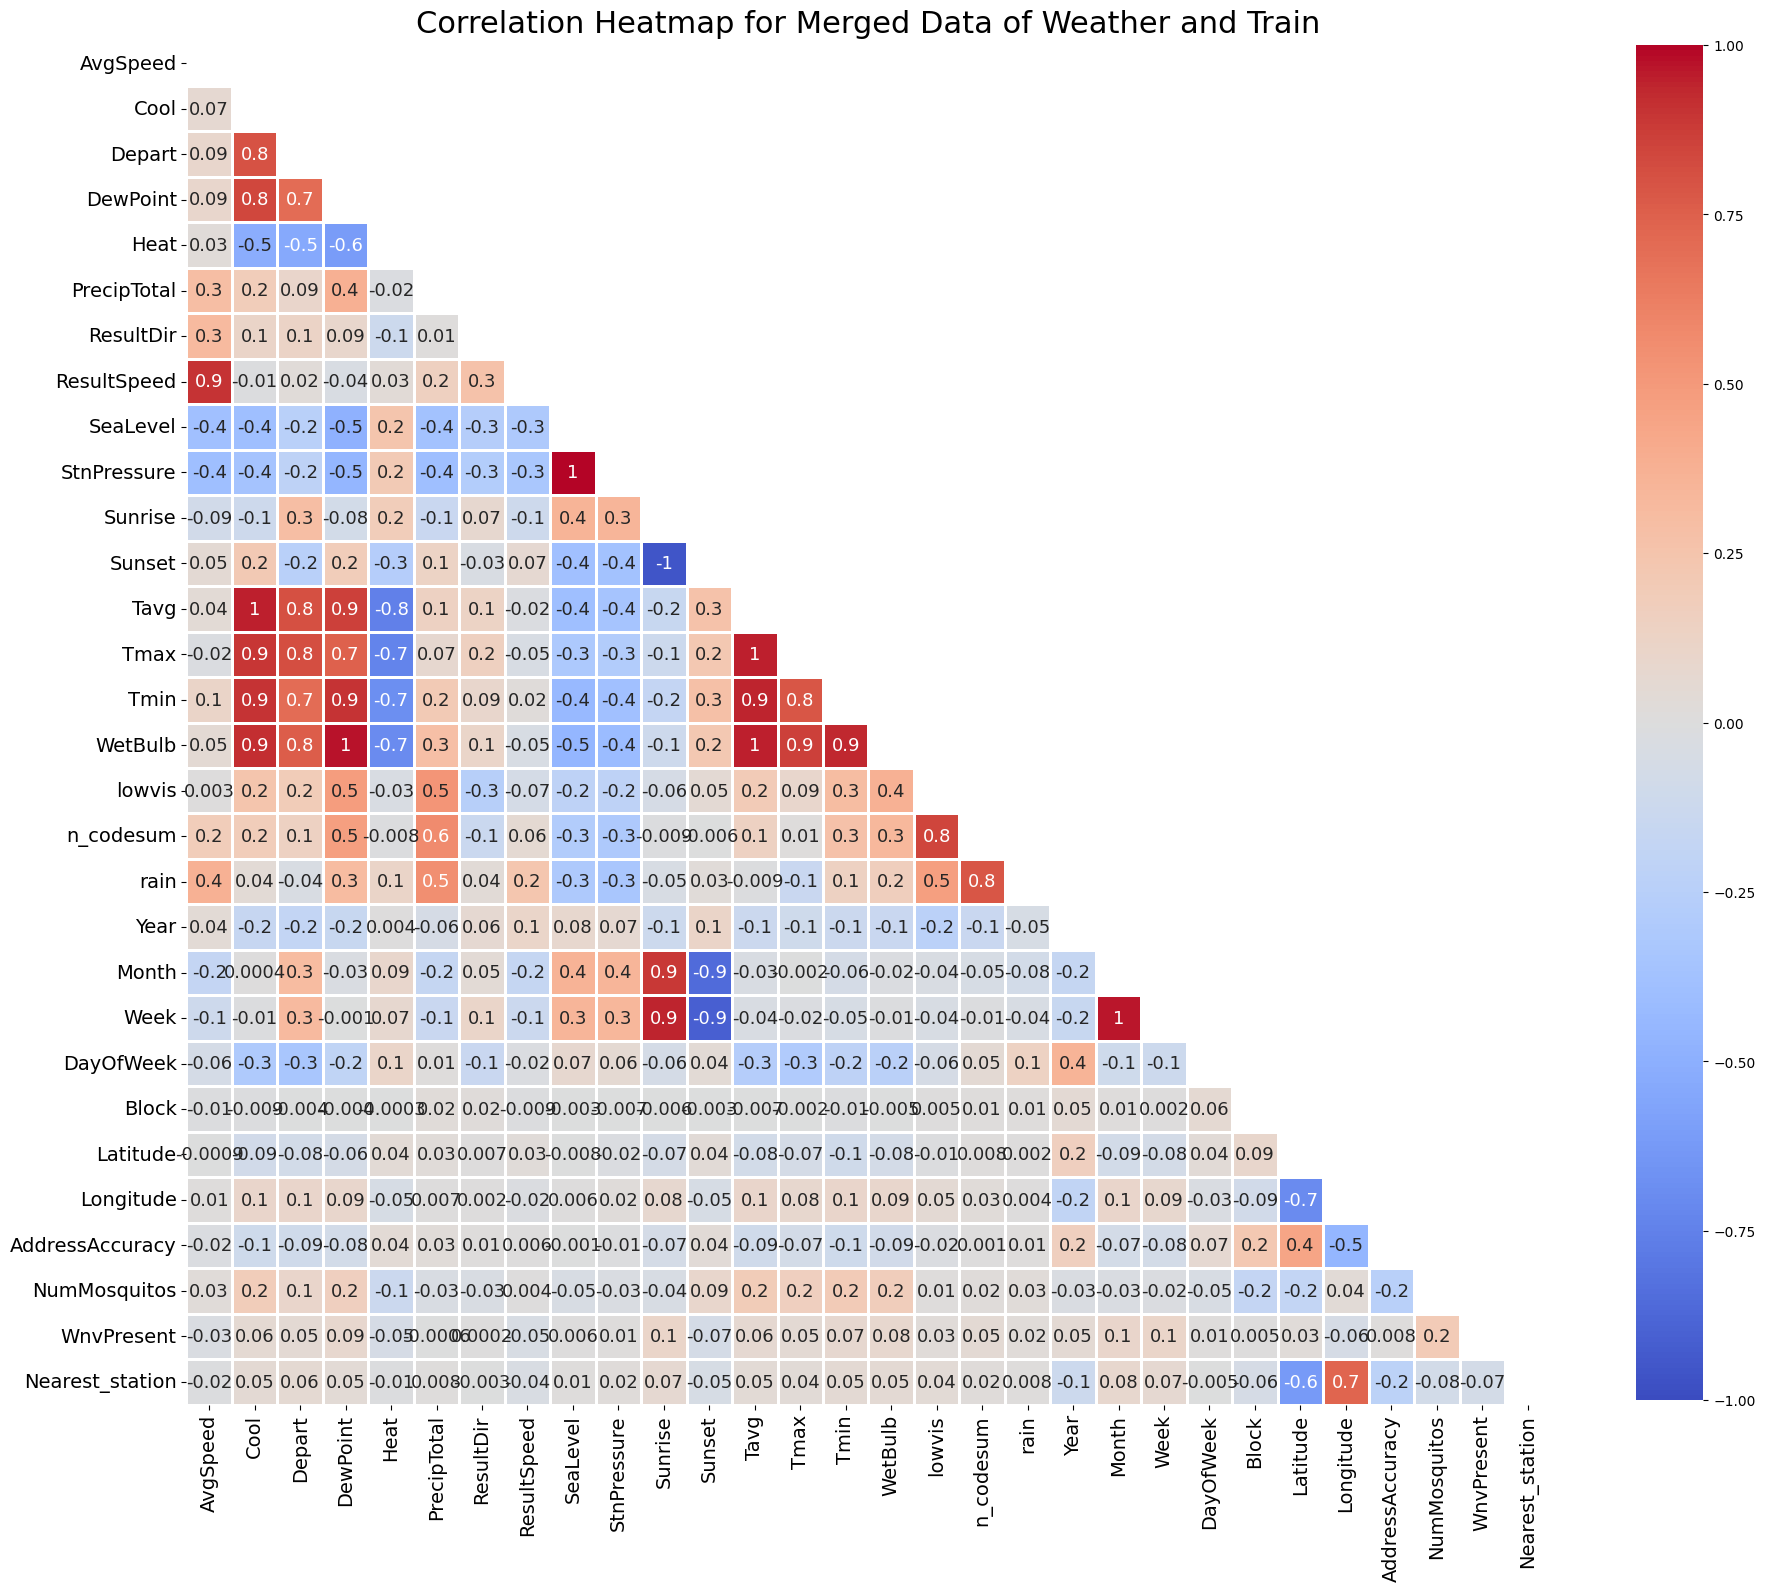

In [7]:
heatmap(merged_df)

From the heatmap above, all our features are generally have a very low correlation to `WnvPresent` (target variable). There are a lot of the multicollinearity whereby the predictor variables have very high correlation between each other. 

Due to the low correlation of the predictor variable to the target variable, we will perform the feature engineering process by constructing new features from existing predictor variables.

In [8]:
mapdata = np.loadtxt("./datasets/mapdata_copyright_openstreetmap_contributors.txt")

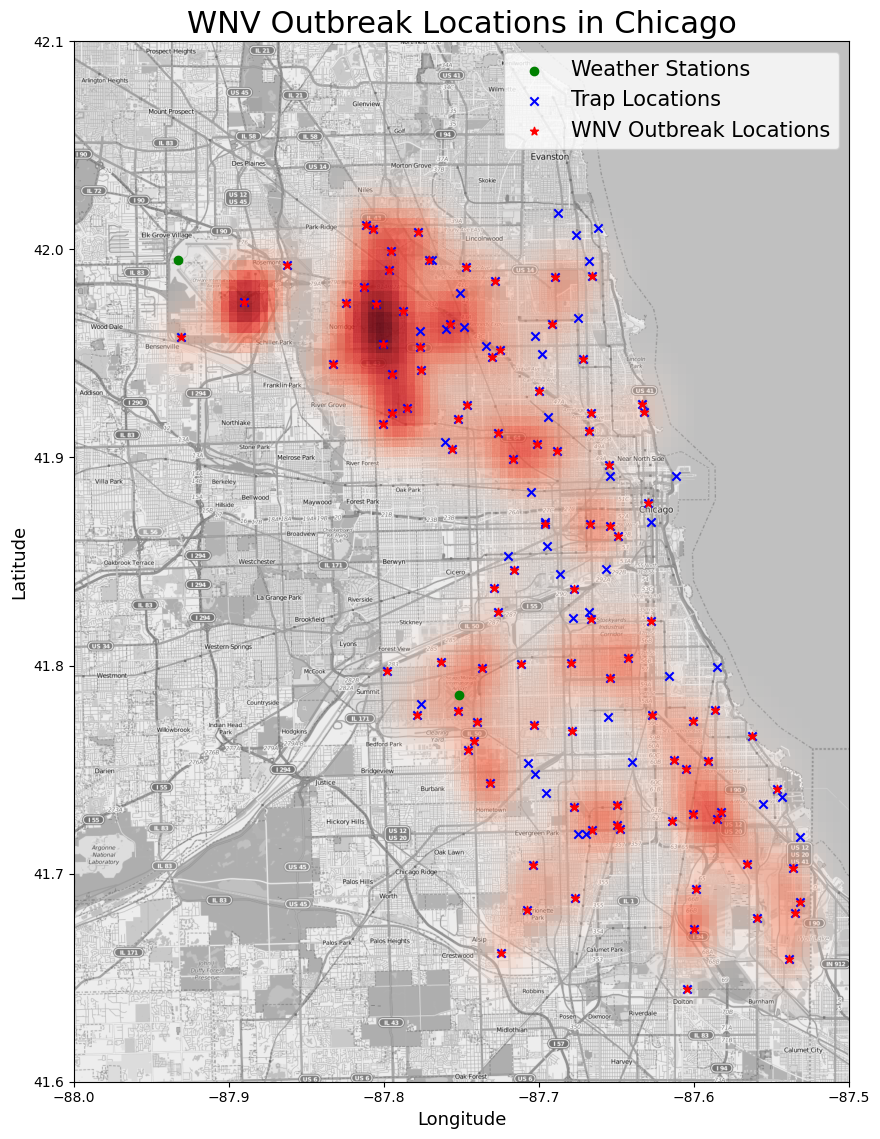

In [9]:
# plot a map of the WNV outbreaks
# Code is borrowed from: https://www.kaggle.com/users/213536/vasco/predict-west-nile-virus/west-nile-heatmap

alpha_cm1 = plt.cm.Reds
alpha_cm1._init()
alpha_cm1._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm1.N) / 10 - 1)[::-1]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

#Traps where only WNV is present
wnv = train[train['WnvPresent'] == 1]
wnv = wnv.groupby(['Date', 'Trap','Longitude', 'Latitude'])['WnvPresent'].max().reset_index()
X1 = wnv[['Longitude', 'Latitude']].values
kd1 = KernelDensity(bandwidth=0.015)
kd1.fit(X1)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv1 = np.exp(kd1.score_samples(gridpoints).reshape(100,100))

#kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv1, origin='lower', cmap=alpha_cm1, extent=lon_lat_box, aspect=aspect)

# weather stations
station1 = [-87.933, 41.995]
station2 = [-87.752, 41.786]
station_locations = np.array([station1] + [station2])
plt.scatter(station_locations[:,0], station_locations[:,1], marker='o', c='g', label='Weather Stations')

# trap locations
trap_locations = train[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(trap_locations[:,0], trap_locations[:,1], marker='x', c='blue', label='Trap Locations')

# wnn outbreak locations
wnv_locations = train[train['WnvPresent'] != 0][['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(wnv_locations[:,0], wnv_locations[:,1], marker='*', c='r', label='WNV Outbreak Locations')

plt.title('WNV Outbreak Locations in Chicago', fontsize = 22)
plt.legend(fontsize=15)
plt.xlabel('Longitude', fontsize=13)
plt.ylabel('Latitude', fontsize=13)
plt.savefig('./assets/WNV Outbreak Locations.png') # Add this when copying to a script on Kaggle

We wanted to get a better visual of what our data was telling us geographically. The green circles are where the weather stations are located, the blue crosses indicate the location of the traps placed for catching mosquitoes, the red stars indicate the location of the WNV outbreak, and the red markings describe the areas that were infected. The area with the darker red indicates that the region has more WNV outbreak occurrences, and the opposite is true for areas with a lighter red.

From the map, we observed that WNV is more prevalent near bodies of water and O'Hare Airport. With this helpful visualization of WNV outbreak locations, CDPH and the City of Chicago can make more informed decisions on areas of hotspots and thus give a higher priority to spraying resources in these areas.

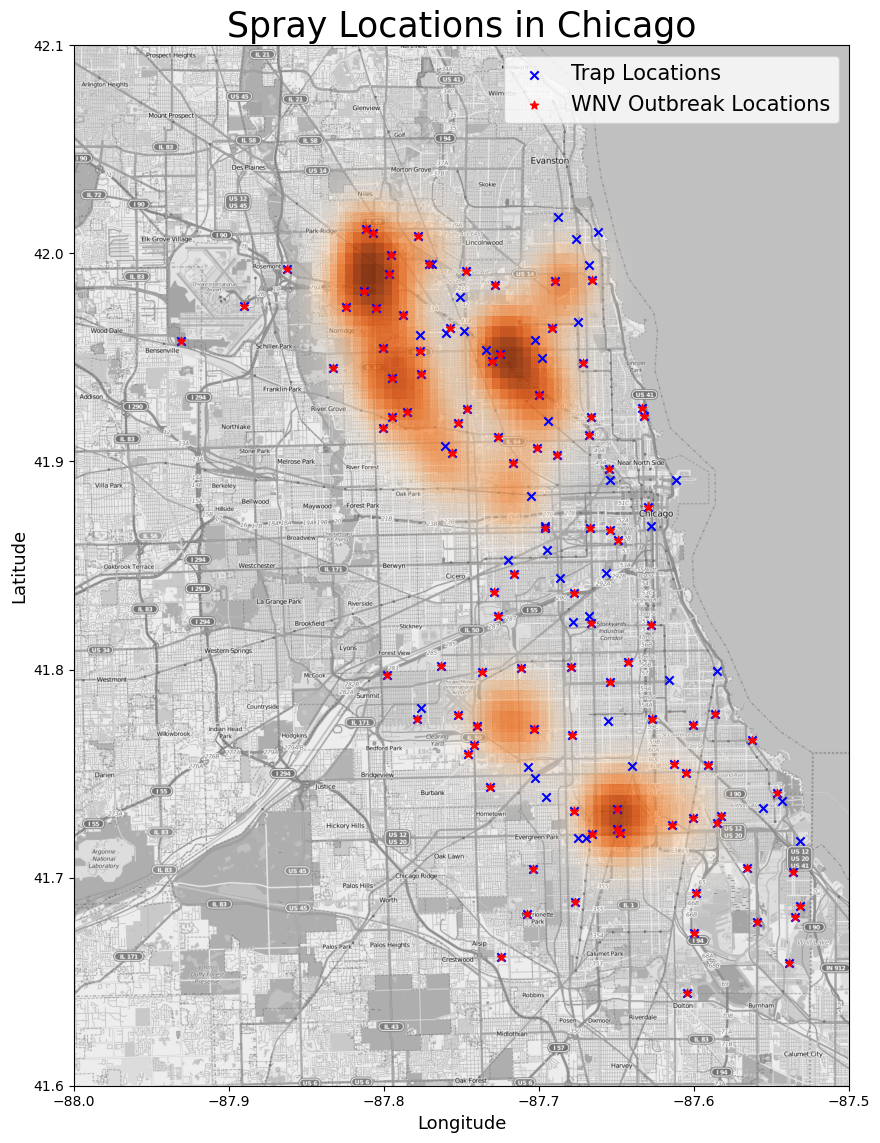

In [10]:
# plot map of the WNV outbreaks vs spray
alpha_cm = plt.cm.Oranges
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# Spray location
X = spray[['Longitude', 'Latitude']].drop_duplicates().values
kd = KernelDensity(bandwidth=0.015)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

#kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)

# trap locations
trap_locations = train[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(trap_locations[:,0], trap_locations[:,1], marker='x', c='blue', label='Trap Locations')

# wnn outbreak locations
wnv_locations = train[train['WnvPresent'] != 0][['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(wnv_locations[:,0], wnv_locations[:,1], marker='*', c='r', label='WNV Outbreak Locations')

plt.title('Spray Locations in Chicago', fontsize=25)
plt.legend(fontsize=15)
plt.xlabel('Longitude', fontsize=13)
plt.ylabel('Latitude', fontsize=13)
plt.savefig('./assets/Spray Locations.png')

The above map shows us the visualization of spraying locations in Chicago. Area with the darker orange indicates that the region has more spray concentration area and the area with lighter orange means that less spray concentration area.

From the map, we have discovered that all the traps are spread out well geographically, however the spraying fails to fully overlap with the virus outbreak. This is a cause for concern and it can be because of multiple reasons e.g. - improper spraying practices, resources constraint. We will explore this further in the modelling and cost benefit analysis.

## NumMosquitos EDA

In [11]:
# calculate the breakdown of species present in trap
print("Breakdown of species captured in percentage (%): ")
round((train[['Species', 'NumMosquitos']].groupby(by='Species').sum()/ train['NumMosquitos'].sum()) * 100, 2)

Breakdown of species captured in percentage (%): 


NumMosquitos
Species                             
CULEX ERRATICUS                 0.01
CULEX PIPIENS                  33.08
CULEX PIPIENS/RESTUANS         49.07
CULEX RESTUANS                 17.35
CULEX SALINARIUS                0.11
CULEX TARSALIS                  0.01
CULEX TERRITANS                 0.38

In [12]:
# calculate the breakdown of yearly mosquito in trap
print("Breakdown of yearly and monthly mosquito in trap:")
train[['Year', 'Month', 'NumMosquitos']].groupby(by=['Year', 'Month']).sum()

Breakdown of yearly and monthly mosquito in trap:


NumMosquitos
Year Month              
2007 5                40
     6               428
     7              7199
     8             40015
     9              9300
     10             1706
2009 5               190
     6              7390
     7              8833
     8              2346
     9              2137
     10              212
2011 6              4049
     7              8445
     8              2968
     9              3337
2013 6              4711
     7             12771
     8             12707
     9              6255

In [13]:
# calculate the breakdown of yearly mosquito in trap
print("Breakdown of yearly and weekly mosquito in trap:")
train[['Year', 'Week', 'NumMosquitos']].groupby(by=['Year', 'Week']).sum()

Breakdown of yearly and weekly mosquito in trap:


NumMosquitos
Year Week              
2007 22              40
     23             127
     26             301
     27             240
     28            1103
     29            1540
     30            4316
     31           10006
     32            6473
     33           11131
     34            7657
     35            4748
     36            4056
     37            1193
     38            2148
     39            1903
     40            1373
     41             333
2009 22             190
     23            1268
     24            1204
     25            1046
     26            2969
     27             903
     28            1715
     29            3262
     30            1215
     31            2641
     32             878
     33             602
     35             866
     36             129
     38            1306
     39             702
     40             212
2011 23             429
     24             830
     25             846
     26            1944
     28            4588
     30            3857
     31            1065
     32             824
     33             589
     34             490
     35             870
     37            1555
     38             728
     39             184
2013 23             360
     24            1670
     25            1319
     26            1362
     28            6629
     29            4168
     30            1974
     31            2865
     32            3188
     33            1946
     34            2063
     35            2645
     36            2510
     37            2210
     38            1030
     39             505

In [14]:
# dataframe of mosquito species present in traps by year & week
temp_dict ={}
for k,v in enumerate (train['Year'].unique()):
    temp_dict[v]= train[train['Year']==v].groupby(['Week','Species'])['NumMosquitos'].sum()
species_yr_wk = pd.DataFrame(temp_dict).fillna(0)
species_yr_wk['Sum']=species_yr_wk.sum(axis=1)
species_yr_wk

2007    2009    2011    2013     Sum
Week Species                                                       
22   CULEX PIPIENS              1.0     3.0     0.0     0.0     4.0
     CULEX PIPIENS/RESTUANS    10.0   104.0     0.0     0.0   114.0
     CULEX RESTUANS            29.0    83.0     0.0     0.0   112.0
23   CULEX PIPIENS              6.0    45.0     8.0     0.0    59.0
     CULEX PIPIENS/RESTUANS    28.0   724.0    95.0   123.0   970.0
     CULEX RESTUANS            93.0   497.0   311.0   236.0  1137.0
     CULEX SALINARIUS           0.0     0.0     6.0     0.0     6.0
     CULEX TERRITANS            0.0     2.0     9.0     1.0    12.0
24   CULEX PIPIENS              0.0    58.0     5.0     0.0    63.0
     CULEX PIPIENS/RESTUANS     0.0   527.0   276.0   491.0  1294.0
     CULEX RESTUANS             0.0   618.0   520.0  1179.0  2317.0
     CULEX SALINARIUS           0.0     1.0    27.0     0.0    28.0
     CULEX TERRITANS            0.0     0.0     2.0     0.0     2.0
25   CULEX PIPIENS              0.0    47.0     3.0     0.0    50.0
     CULEX PIPIENS/RESTUANS     0.0   665.0   303.0   396.0  1364.0
     CULEX RESTUANS             0.0   333.0   537.0   923.0  1793.0
     CULEX SALINARIUS           0.0     1.0     2.0     0.0     3.0
     CULEX TERRITANS            0.0     0.0     1.0     0.0     1.0
26   CULEX PIPIENS             14.0    14.0    43.0     0.0    71.0
     CULEX PIPIENS/RESTUANS    93.0  2578.0  1093.0  1029.0  4793.0
     CULEX RESTUANS           193.0   368.0   786.0   333.0  1680.0
     CULEX SALINARIUS           1.0     8.0     1.0     0.0    10.0
     CULEX TERRITANS            0.0     1.0    21.0     0.0    22.0
27   CULEX PIPIENS              4.0     6.0     0.0     0.0    10.0
     CULEX PIPIENS/RESTUANS   132.0   854.0     0.0     0.0   986.0
     CULEX RESTUANS           100.0    43.0     0.0     0.0   143.0
     CULEX SALINARIUS           4.0     0.0     0.0     0.0     4.0
28   CULEX PIPIENS             83.0    57.0    69.0     0.0   209.0
     CULEX PIPIENS/RESTUANS   779.0  1200.0  2607.0  2785.0  7371.0
     CULEX RESTUANS           234.0   453.0  1866.0  3841.0  6394.0
     CULEX SALINARIUS           4.0     3.0     9.0     0.0    16.0
     CULEX TERRITANS            3.0     2.0    37.0     3.0    45.0
29   CULEX PIPIENS            216.0    95.0     0.0    11.0   322.0
     CULEX PIPIENS/RESTUANS  1109.0  2513.0     0.0  2210.0  5832.0
     CULEX RESTUANS           201.0   649.0     0.0  1946.0  2796.0
     CULEX SALINARIUS           5.0     4.0     0.0     1.0    10.0
     CULEX TERRITANS            9.0     1.0     0.0     0.0    10.0
30   CULEX PIPIENS           2920.0    30.0   429.0    40.0  3419.0
     CULEX PIPIENS/RESTUANS  1302.0   911.0  2550.0   919.0  5682.0
     CULEX RESTUANS            90.0   268.0   857.0  1010.0  2225.0
     CULEX SALINARIUS           3.0     2.0     2.0     0.0     7.0
     CULEX TERRITANS            1.0     4.0    19.0     5.0    29.0
31   CULEX PIPIENS           4439.0   152.0   108.0   299.0  4998.0
     CULEX PIPIENS/RESTUANS  4725.0  1896.0   778.0  2250.0  9649.0
     CULEX RESTUANS           700.0   586.0   172.0   312.0  1770.0
     CULEX SALINARIUS          15.0     1.0     2.0     2.0    20.0
     CULEX TERRITANS          127.0     6.0     5.0     2.0   140.0
32   CULEX PIPIENS           4470.0    75.0   127.0   654.0  5326.0
     CULEX PIPIENS/RESTUANS  1897.0   560.0   584.0  2131.0  5172.0
     CULEX RESTUANS            63.0   238.0   101.0   403.0   805.0
     CULEX SALINARIUS           2.0     1.0     2.0     0.0     5.0
     CULEX TERRITANS           41.0     4.0    10.0     0.0    55.0
33   CULEX PIPIENS           7761.0    27.0   175.0   764.0  8727.0
     CULEX PIPIENS/RESTUANS  3243.0   462.0   294.0   945.0  4944.0
     CULEX RESTUANS            66.0   112.0   112.0   237.0   527.0
     CULEX SALINARIUS           5.0     1.0     0.0     0.0     6.0
     CULEX TERRITANS           56.0     0.0     8.0     0.0    64.0
34   CULEX PIPIENS 

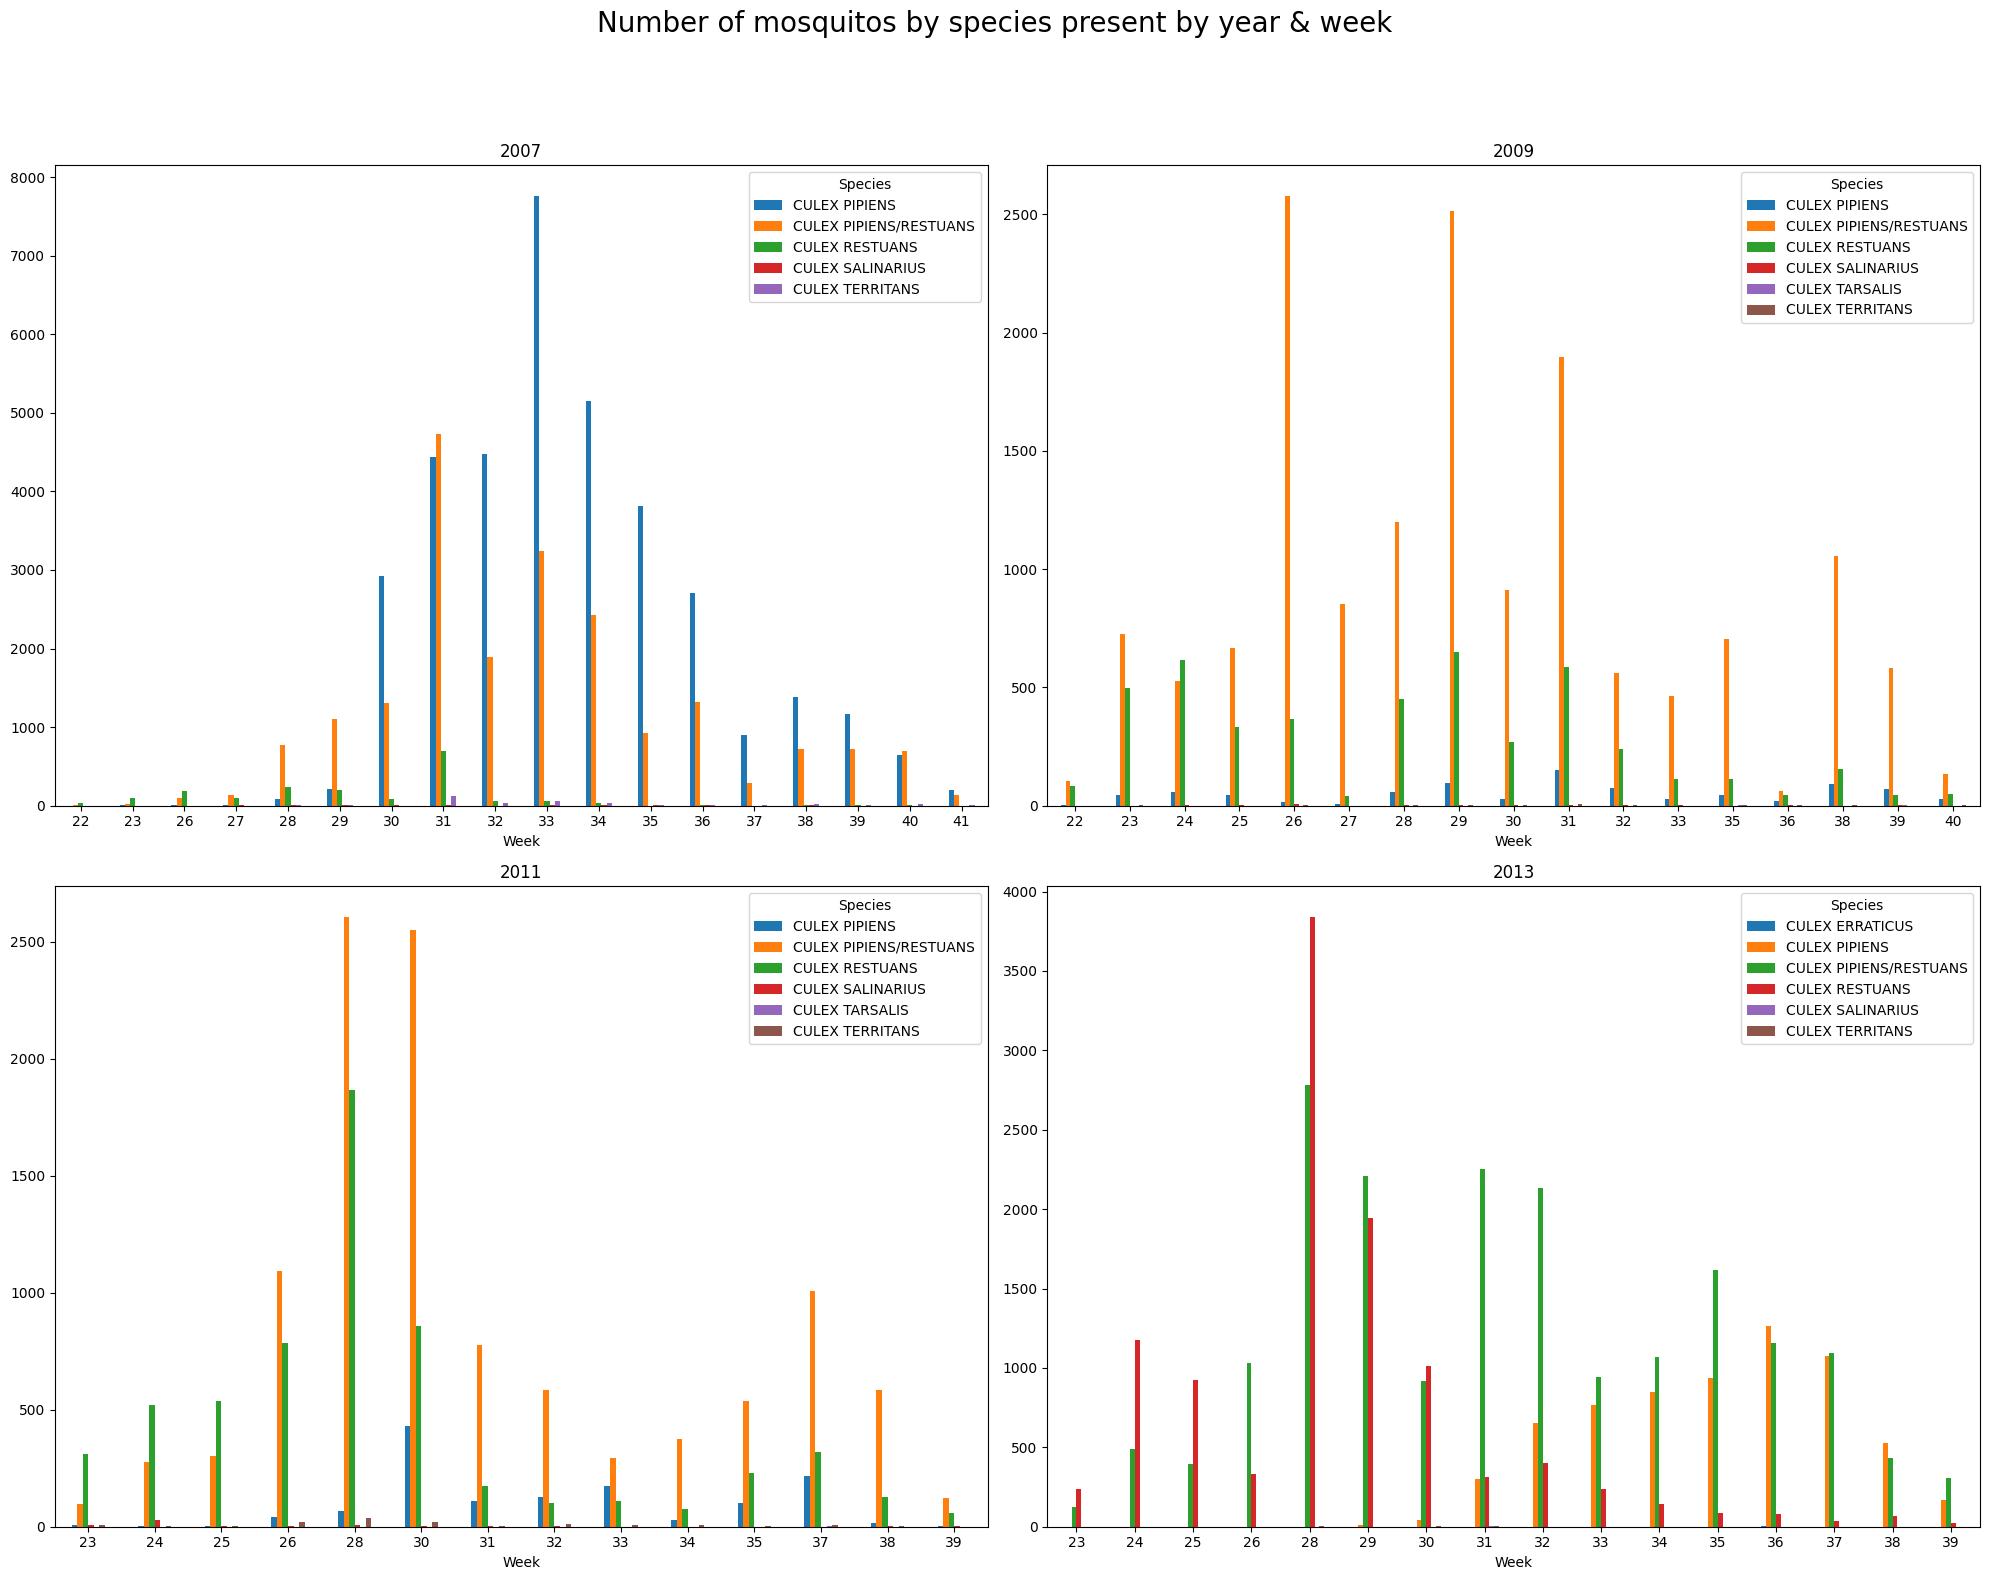

In [15]:
# plots mosquito species present in traps by year & week
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax = ax.ravel()
plt.suptitle('Number of mosquitos by species present by year & week', fontsize=20, y=1.05)
for k, v in enumerate(train['Year'].unique()):
    train[train['Year']==v].groupby(['Week','Species'])['NumMosquitos'].sum().unstack(fill_value=0).plot.bar(ax=ax[k])
    ax[k].set_title(v)
    ax[k].tick_params(axis='x', labelrotation=0)
plt.tight_layout()

The plots above shows the distribution of number of mosquitoes (by species) between the period of Week 22 - 41 in the years 2007, 2009, 2011 and 2013.

- The number of mosquitoes in 2007 is the highest amongst the rest, with the peak at over 40,000 mosquitoes in August.
- The number of mosquitoes increases from week 23 and generally peaks at week 28 - 33


## WnvPresent EDA

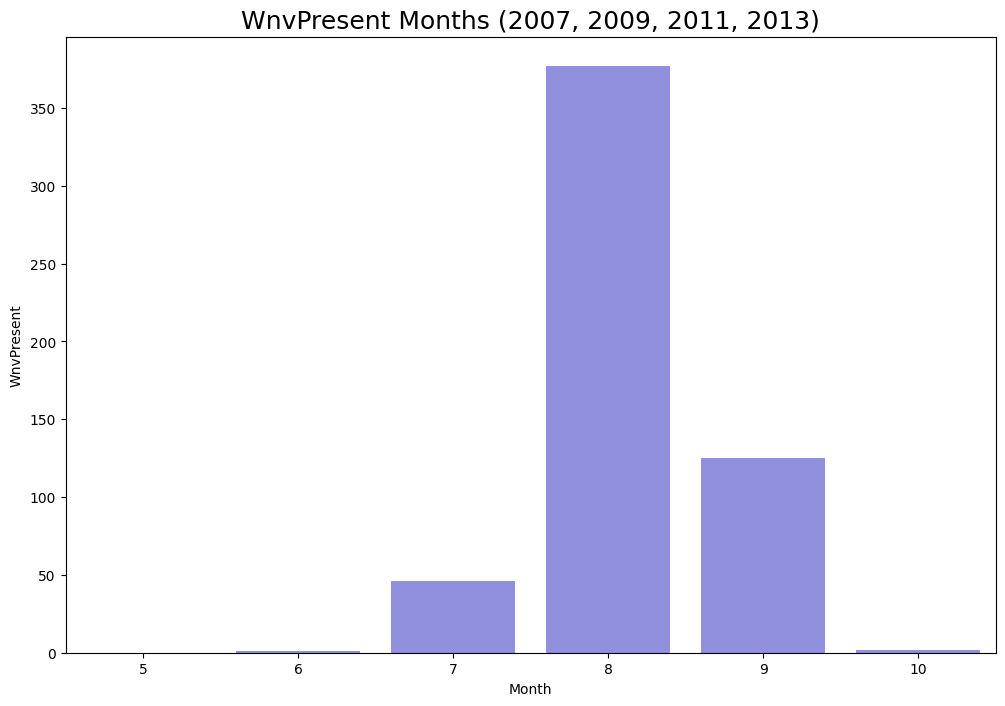

In [16]:
# August tends to have higher occurences of the West Nile Virus
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.barplot(data=train.groupby(by='Month').sum().reset_index(), x='Month', y='WnvPresent', color='#8383EC', ax=ax)
plt.title('WnvPresent Months (2007, 2009, 2011, 2013)', fontsize=18);

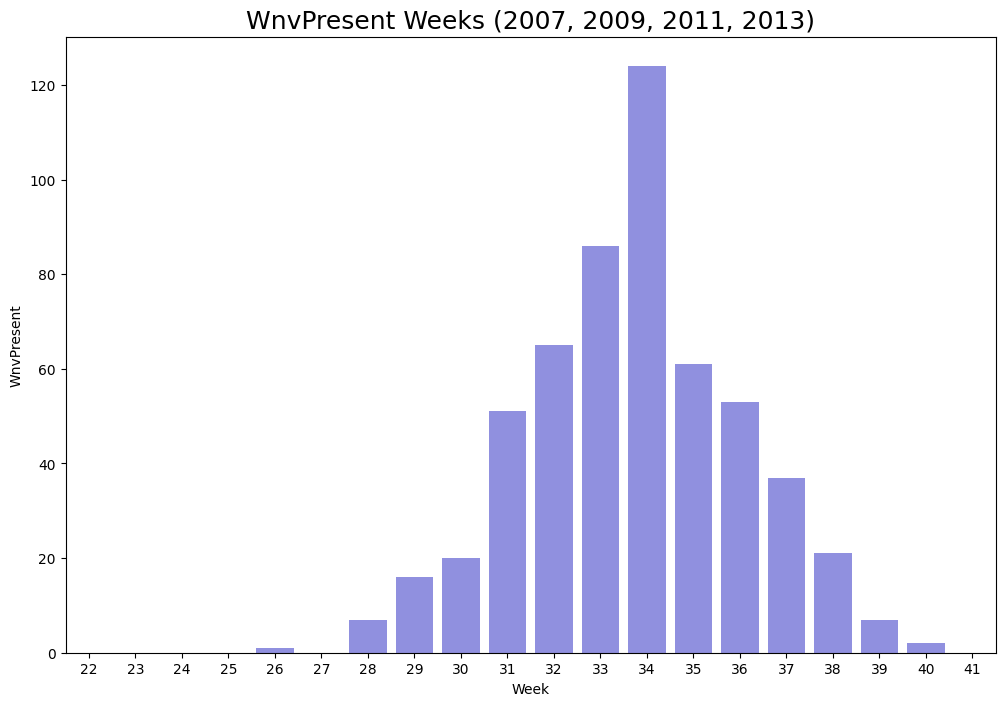

In [17]:
# Weeks 33-34 tend to have higher incidences of the West Nile Virus
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.barplot(data=train.groupby(by='Week').sum().reset_index(), x='Week', y='WnvPresent', color='#8383EC', ax=ax)
plt.title('WnvPresent Weeks (2007, 2009, 2011, 2013)', fontsize=18);

From the month’s graph, we can see that the WNV cases started from July through and reduced in September, which is the summer season in Chicago. 

When we look at the week’s graph, we can see that the WNV cases started from week 26 (between the end of June and early July) and decreased at week 40 (between the end of September and early October). Week 34 (around mid-August) has the highest cases every year. 

Our first instinct from this information is that most of the WNV cases that happened around summertime must be related to the weather which encourages mosquito breeding. We will investigate the weather information later.

   WnvPresent
0       94.76
1        5.24



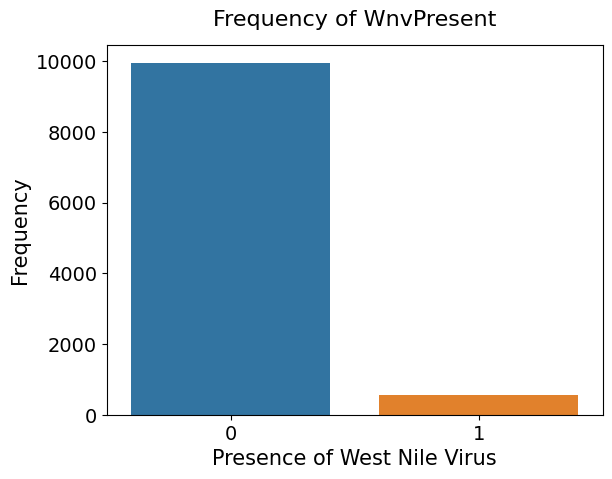

In [18]:
# The target is imbalanced
print(pd.DataFrame(round((train['WnvPresent'].value_counts()/len(train['WnvPresent']))*100, 2)))
print()

sns.barplot(x=[0,1], y=train['WnvPresent'].value_counts())
plt.xlabel('Presence of West Nile Virus', fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.tick_params(labelsize=14)
plt.title('Frequency of WnvPresent',fontsize=16, y=1.03)
plt.show()

The target is highly imbalanced with majority class (94.8%) to be without WNV. This will be taken care of before modelling.

## NumMosquitos and WnvPresent EDA

                        NumMosquitos  WnvPresent  pct_wnv
Species                                                  
CULEX ERRATICUS                    7           0     0.00
CULEX TARSALIS                     7           0     0.00
CULEX SALINARIUS                 145           0     0.00
CULEX TERRITANS                  510           0     0.00
CULEX RESTUANS                 23431          49     0.21
CULEX PIPIENS                  44671         240     0.54
CULEX PIPIENS/RESTUANS         66268         262     0.40



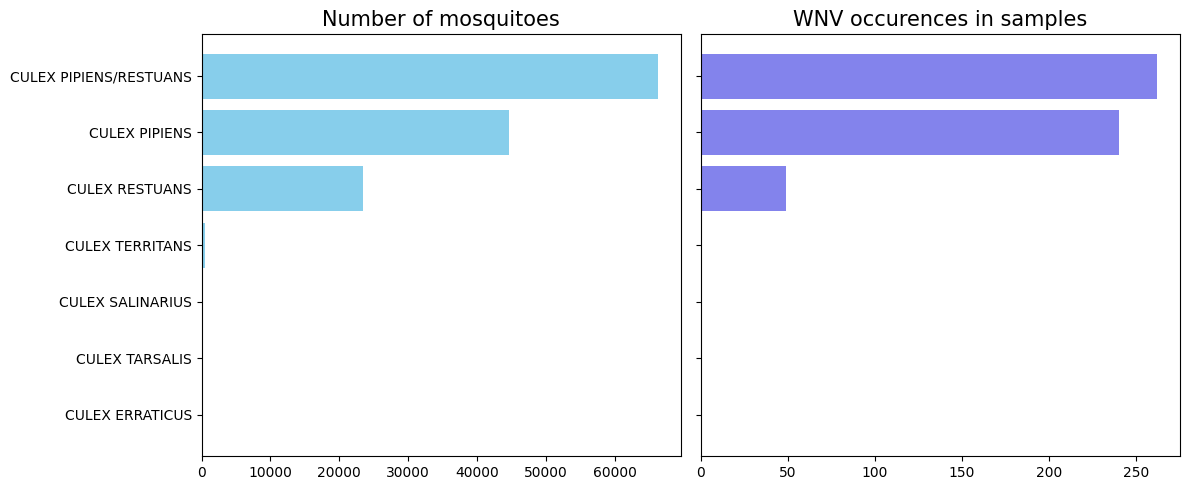

In [19]:
mos_wnv = train[['Species', 'NumMosquitos', 'WnvPresent']].groupby(by='Species').sum()
mos_wnv['pct_wnv']= round((mos_wnv['WnvPresent']/mos_wnv['NumMosquitos']) *100, 2)
mos_wnv = mos_wnv.sort_values('NumMosquitos', ascending=True)
print(mos_wnv)
print()

# reset the index after groupby
mos_wnv.reset_index(inplace=True)

fig, ax = plt.subplots(ncols = 2, figsize=(12,5), sharey=True)

# plot number of mosquitoes
ax[0].barh(mos_wnv['Species'], mos_wnv['NumMosquitos'], color='skyblue')
ax[0].set_title('Number of mosquitoes', fontsize=15)

# plot WNV outbreaks
ax[1].barh(mos_wnv['Species'], mos_wnv['WnvPresent'], color='#8383EC')
ax[1].set_title('WNV occurences in samples', fontsize=15)

plt.tight_layout()

In [20]:
print(f'Percentage of mosquito carrying WNV: {round((mos_wnv["WnvPresent"].sum()/mos_wnv["NumMosquitos"].sum()) *100, 2)}%')

Percentage of mosquito carrying WNV: 0.41%


From the table and graph above, we can see that *Culex Pipiens* and *Culex Restuans* are the most captured mosquitos and the only mosquitos that will carry West Nile Virus, about 0.41 % of the total samples are carrying the virus. Thus, we will be focusing on both mosquitos' activities.

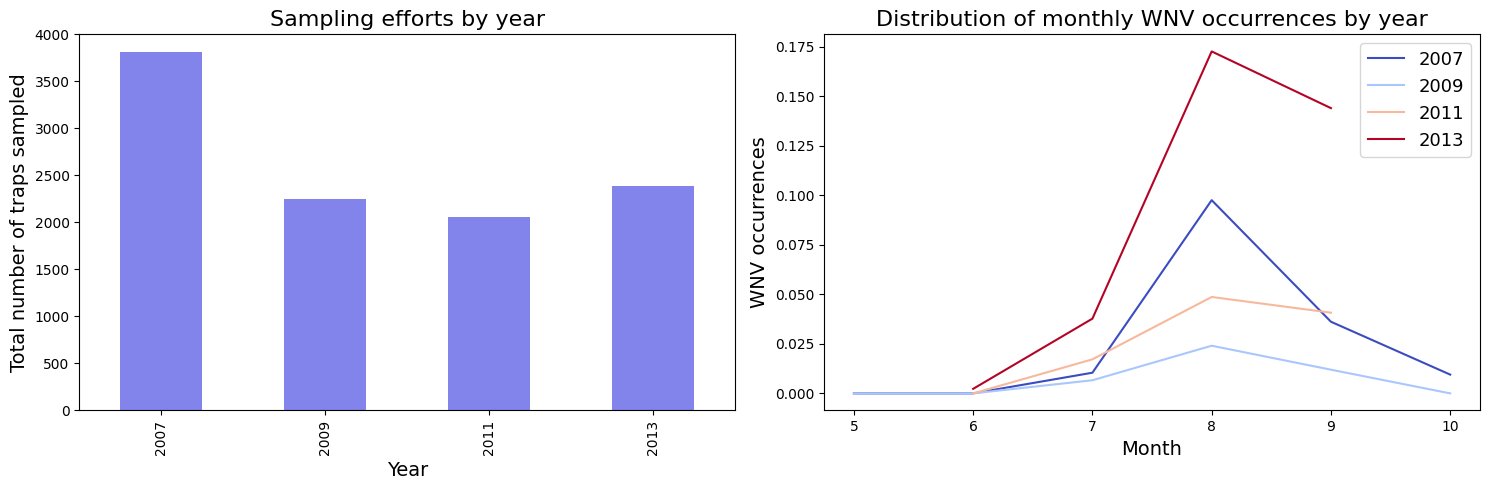

In [21]:
fig, ax = plt.subplots(ncols = 2, figsize=(15,5))

# plot distribution of sampling done by year
train['Year'].value_counts().sort_index().plot(kind = 'bar', ax = ax[0], color='#8383EC')
ax[0].set_title('Sampling efforts by year', fontsize=16)
ax[0].set_xlabel('Year', fontsize=14)
ax[0].set_ylabel('Total number of traps sampled',fontsize=14)

# plot Distribution of monthly WNV occurrences by year
sns.lineplot(data = train, x='Month', y='WnvPresent', hue='Year', ci = None, 
             palette = 'coolwarm', ax = ax[1])
ax[1].legend(fontsize = 13)
ax[1].set_title('Distribution of monthly WNV occurrences by year', fontsize=16)
ax[1].set_xlabel('Month',fontsize=14)
ax[1].set_ylabel('WNV occurrences',fontsize=14)

plt.tight_layout()

The bar chart on the left shows the total number of traps being planned each year. It seems like the Chicago government has reduced the number of traps since 2007, maybe that many traps did not trap the mosquitoes with WNV.

The line graph on the right shows the distribution of the monthly WNV cases each year. We can see that cases started rising in the summer season, June-July, and reached a peak in August, before declining in September. The year 2013 has the highest occurrences of WNV present in the sample.

Year       2007                   2009                2011             2013  \
Month        5  6  7    8   9  10   5  6  7  8  9  10   6   7   8   9    6    
WnvPresent    0  0  6  200  28  2    0  0  5  9  5  0    0  11  24  22    1   

Year                     
Month       7    8   9   
WnvPresent  24  144  70  



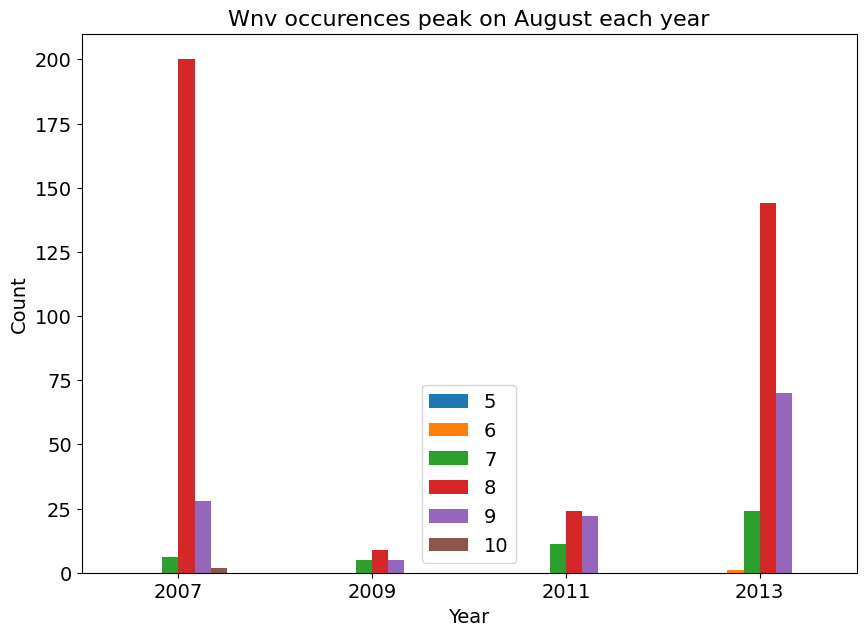

In [22]:
# Wnv occurrence count plot by year & month
wnv_yr = pd.DataFrame(train[['Year', 'Month', 'WnvPresent']].groupby(by=['Year','Month']).sum().T)
print(wnv_yr)
print()

train.groupby(['Year','Month'])['WnvPresent'].sum().unstack().plot.bar(figsize=(10,7))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Wnv occurences peak on August each year', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.show()

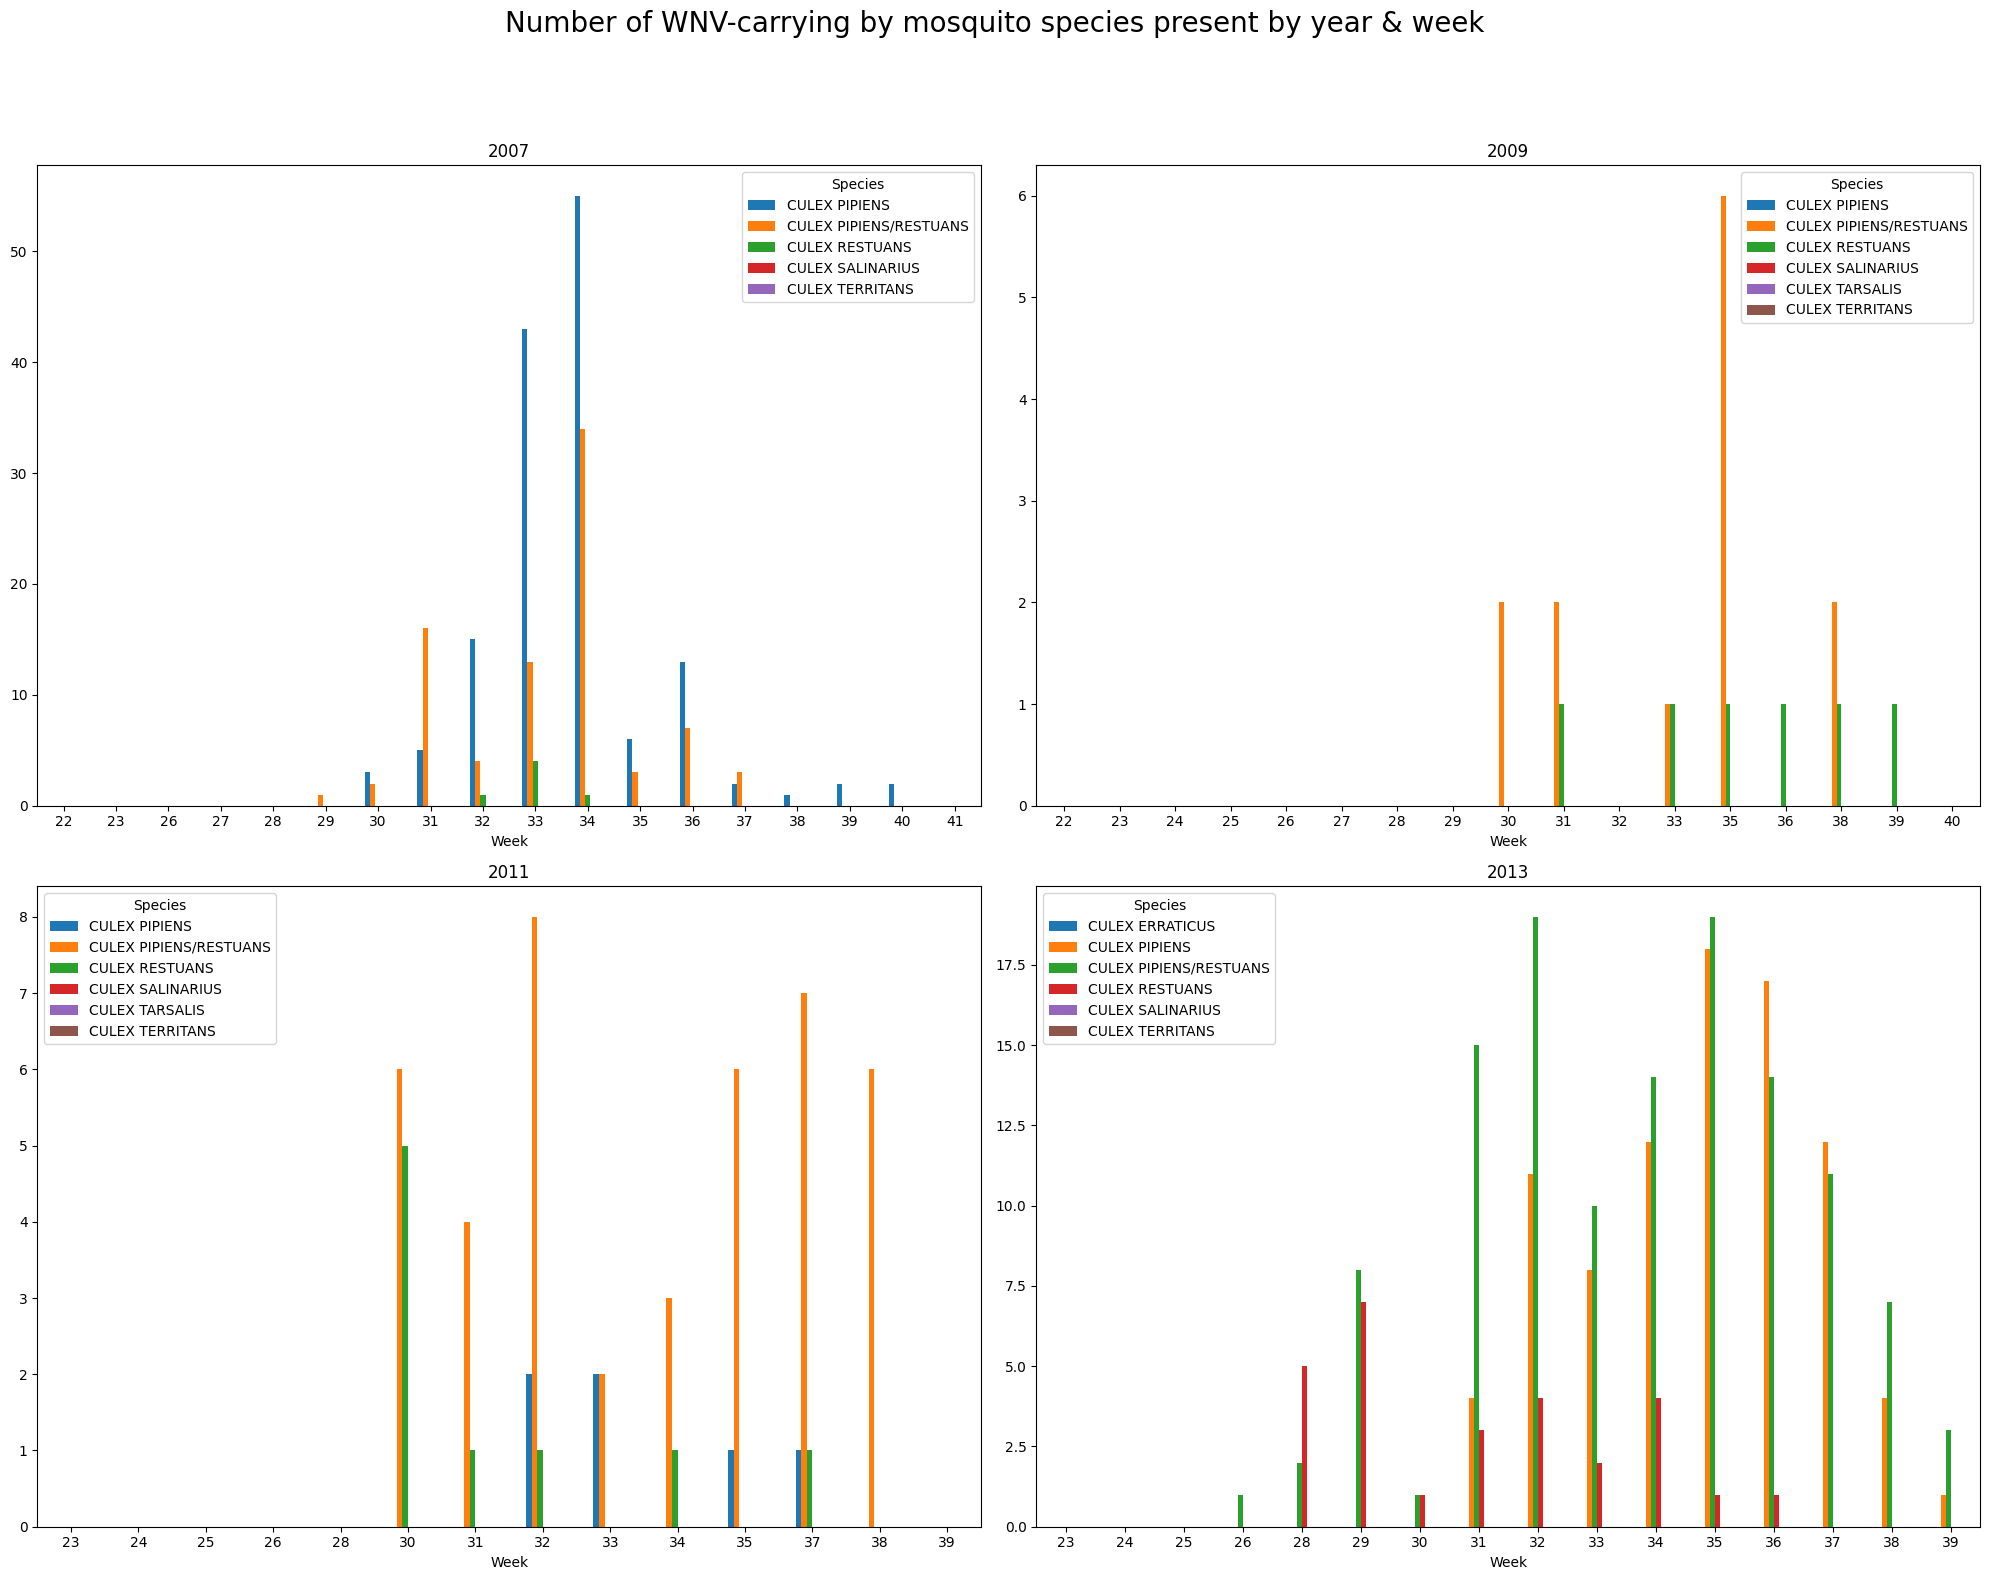

In [23]:
# plots of Wnv-carrying mosquito by year & month
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax = ax.ravel()
plt.suptitle('Number of WNV-carrying by mosquito species present by year & week', fontsize=20, y=1.05)
for i, y in enumerate(train['Year'].unique()):
    train[train['Year']==y].groupby(['Week','Species'])['WnvPresent'].sum().unstack(fill_value=0).plot.bar(ax=ax[i])
    ax[i].set_title(y)
    ax[i].tick_params(axis='x', labelrotation=0)
plt.tight_layout()

The plots above shows the distribution of the WNV-carrying mosquito species between the period of Week 26 - 40 in the 2007, 2009, 2011 and 2013.

- In 2007 and 2013, we can see that Culex Pipiens is the species that carry the WNV most.
- Only 3 mosquito species are detected with the WNV
- We notice a lag in the week that the WNV was present as the numbers spikes at Week 26 onwards on 2013
- It generally peaks at Weeks 32 - 36

In [24]:
def twin_bar_plot(fea1, fea2):
    for yr in merged_df['Year'].unique():
        fig, ax1 = plt.subplots(figsize=(12,6))
        
        kwargs = {'alpha':0.5}
        sns.barplot(x=merged_df[merged_df['Year']==yr]['Month'], y=merged_df[merged_df['Year']==yr][fea1]*100,
                     ci=None, color='#8383EC', label=f'{fea1}', ax=ax1)
        ax1.set_xlabel('Month', fontsize=13)
        ax1.set_ylabel(f'{fea1} (%)', fontsize=13, color='#8383EC')
        ax1.legend(loc=2)
        ax1.set_xticklabels(ax1.get_xticklabels());

        no_mosquito = merged_df[merged_df['Year']==yr].groupby(['Month'])[fea2].sum()
        df_no_mosquito = pd.DataFrame(no_mosquito)

        ax2 = ax1.twinx()
        sns.barplot(x=df_no_mosquito.index, y=df_no_mosquito[fea2]/1000,
                     ci=None, color='r', label=f'{fea2}', ax=ax2, **kwargs)
        ax2.set_ylabel(f'{fea2} in thousands', fontsize=13, color='r')
        ax2.legend(loc=1)

        plt.title(f'{fea1} and {fea2} in {yr}')

        fig.tight_layout()

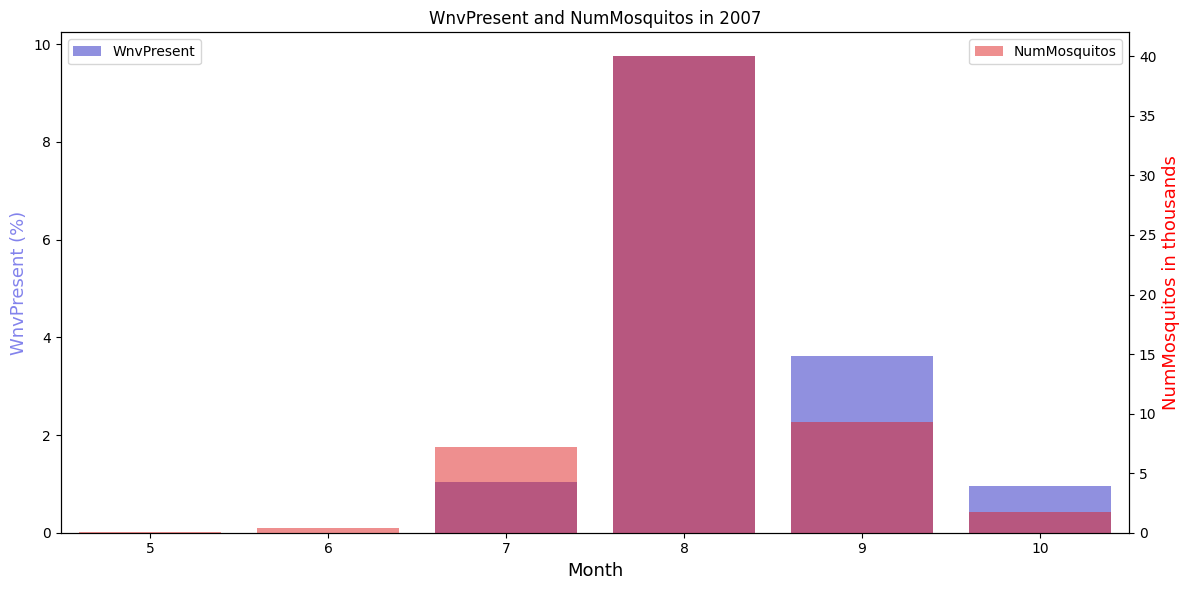

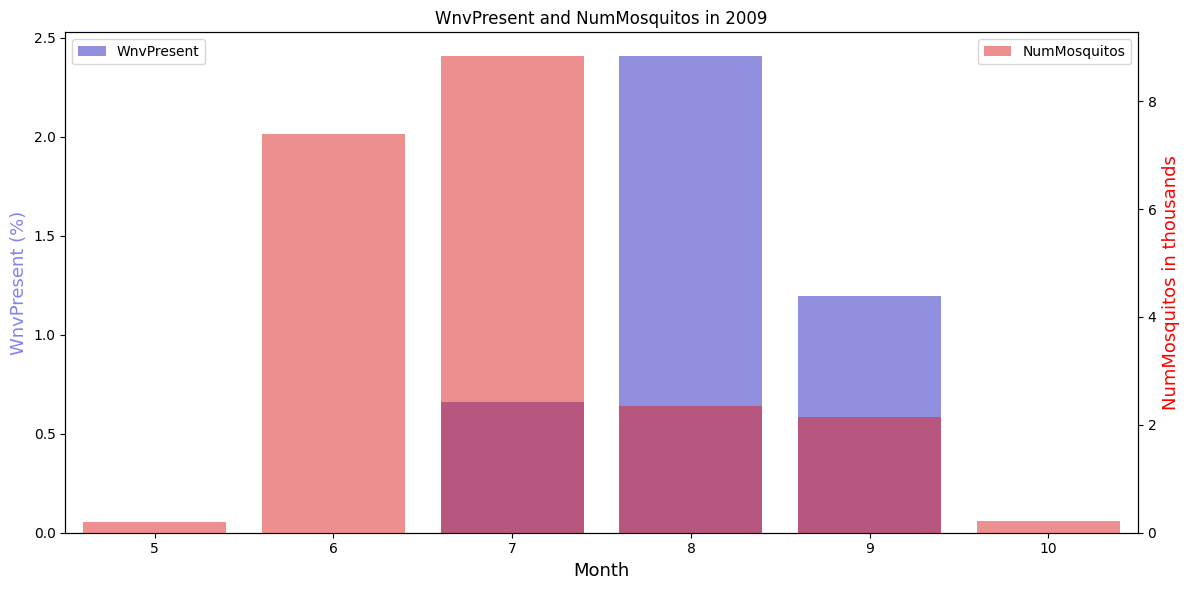

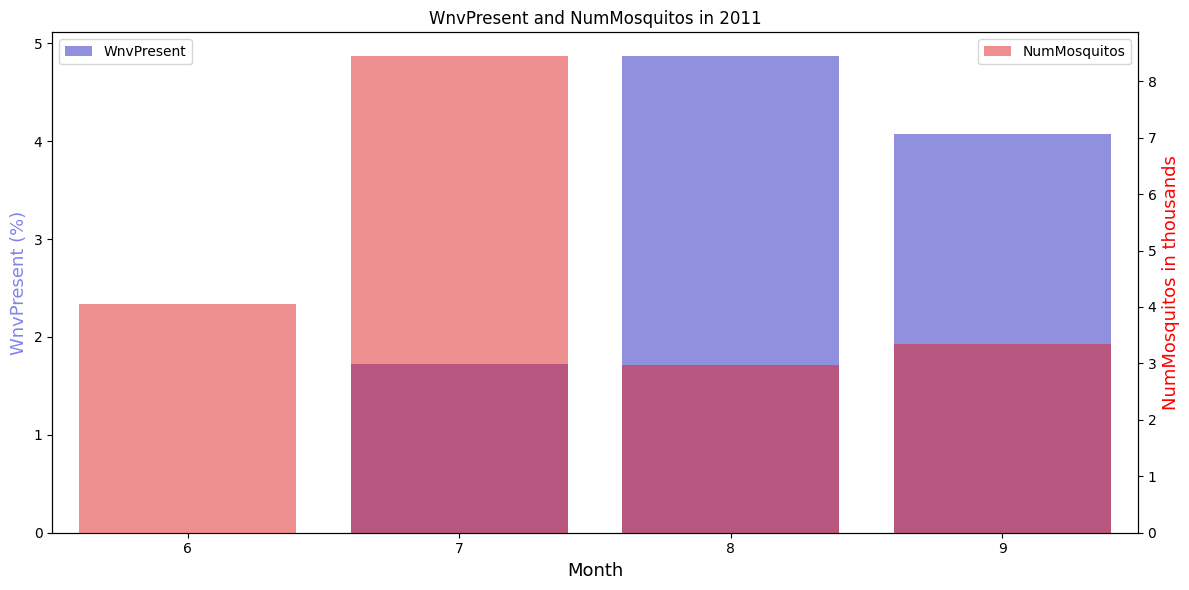

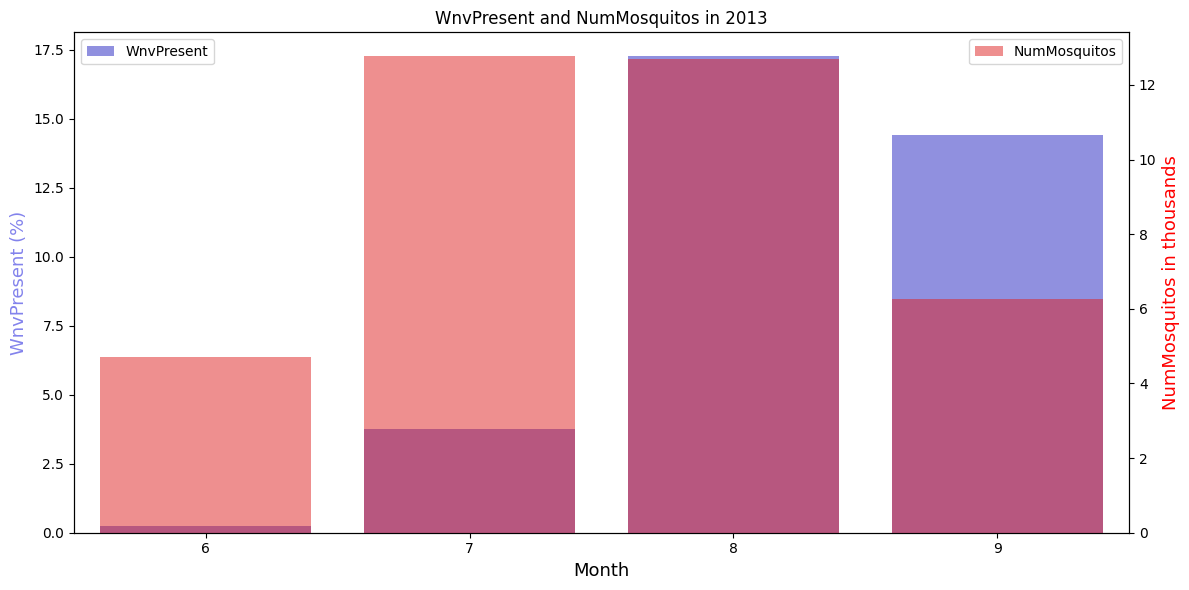

In [25]:
twin_bar_plot('WnvPresent', 'NumMosquitos')

When we look at the relationship between the number of mosquitoes and the presence of WNV in them, there might not be a clear correlation to between presence of WNV to the number of mosquitoes.

We could then infer other that there are other direct causes to this. For example, we understand that the main carriers of WNV are infected birds and mosquitoes are simply a medium for which the WNV is being transmitted.

It is no surprise that the number of mosquitoes would not directly affect the presence of WNV.

## Weather effect on WNV

Now analyse how the weather information has impacts on the occurrence of WNV.

### DewPoint & WetBulb

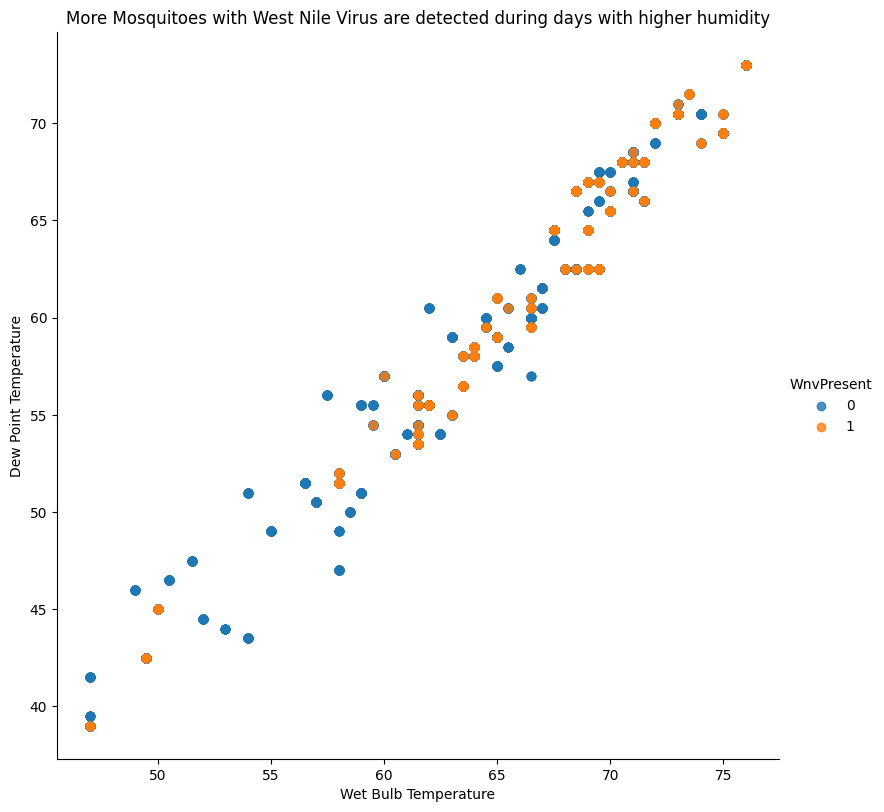

In [26]:
sns.lmplot( x='WetBulb', y='DewPoint', data=merged_df, fit_reg=False, hue='WnvPresent', height=8)
plt.title('More Mosquitoes with West Nile Virus are detected during days with higher humidity')
plt.xlabel('Wet Bulb Temperature')
plt.ylabel('Dew Point Temperature')
plt.show();

When the wet bulb temperature exceeds 59° Fahrenheit and dew point temperature exceeds 50° Fahrenheit, it will create a humid environment that is important to the mosquito's activities. Thus, we can see the more mosquitoes with WNV are detected.

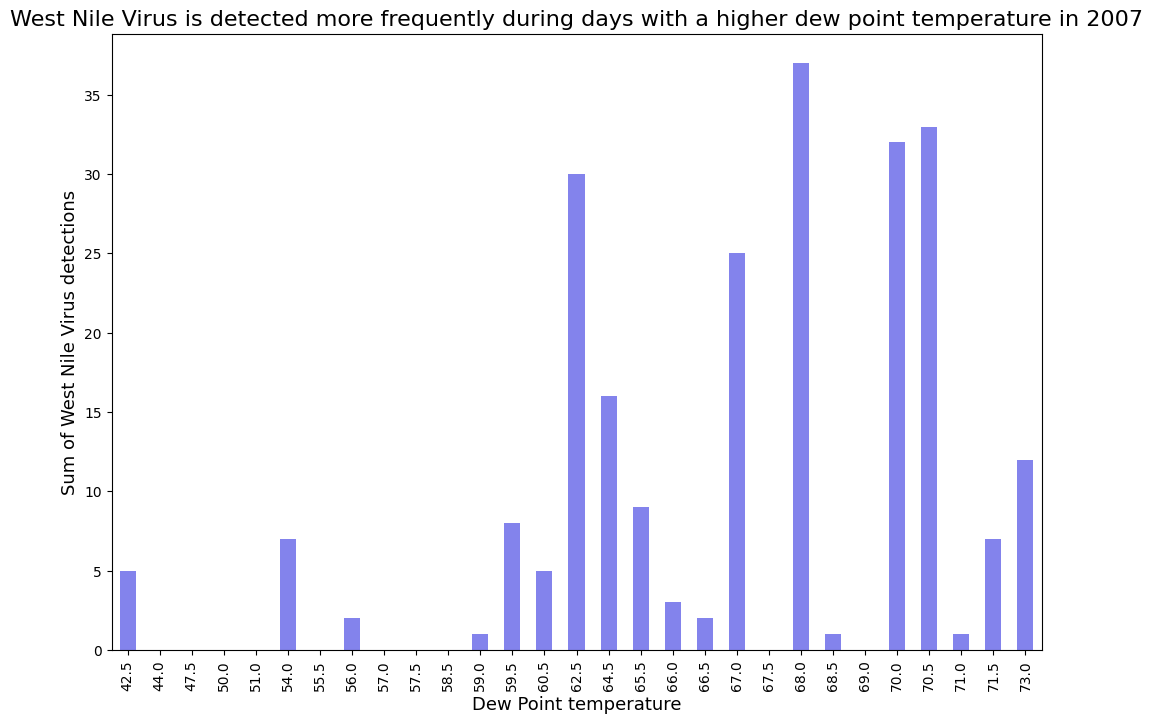

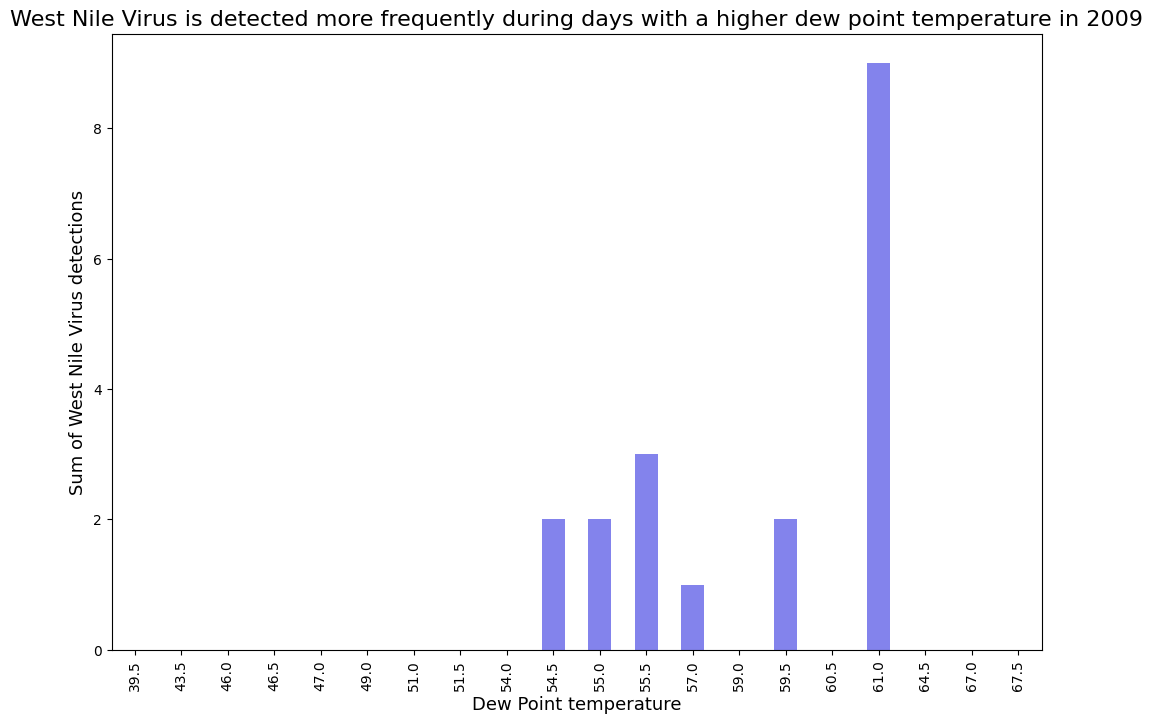

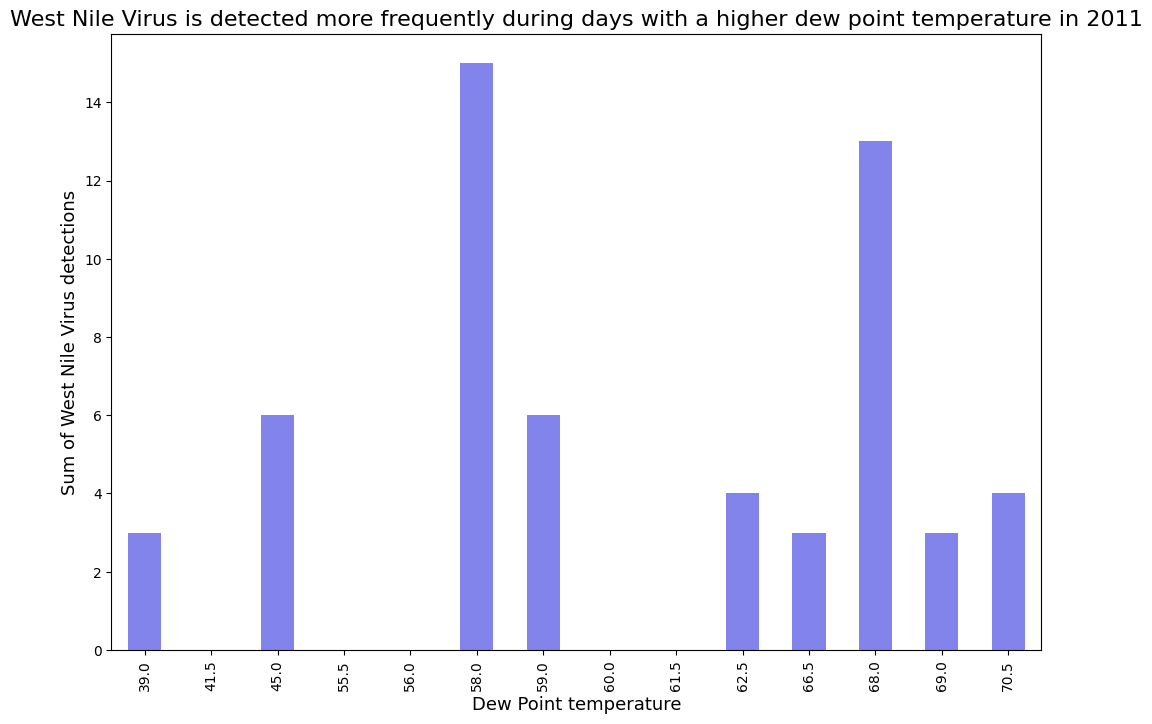

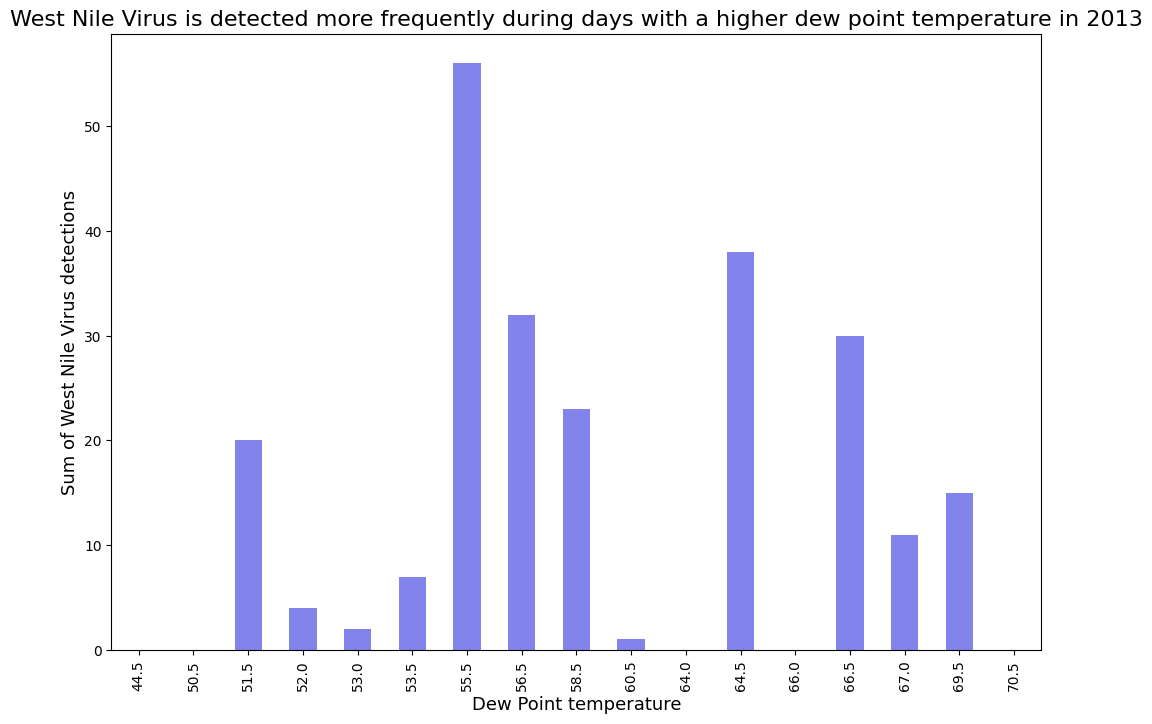

In [27]:
for x in merged_df['Year'].unique():
    plt.figure(figsize=(12,8))
    merged_df[merged_df['Year']==x].groupby(['DewPoint'])['WnvPresent'].sum().plot.bar(color='#8383EC') 
    plt.title(f"West Nile Virus is detected more frequently during days with a higher dew point temperature in {x}", fontsize=16)
    plt.xlabel("Dew Point temperature", fontsize =13)
    plt.xticks(rotation=90)
    plt.ylabel("Sum of West Nile Virus detections", fontsize=13)

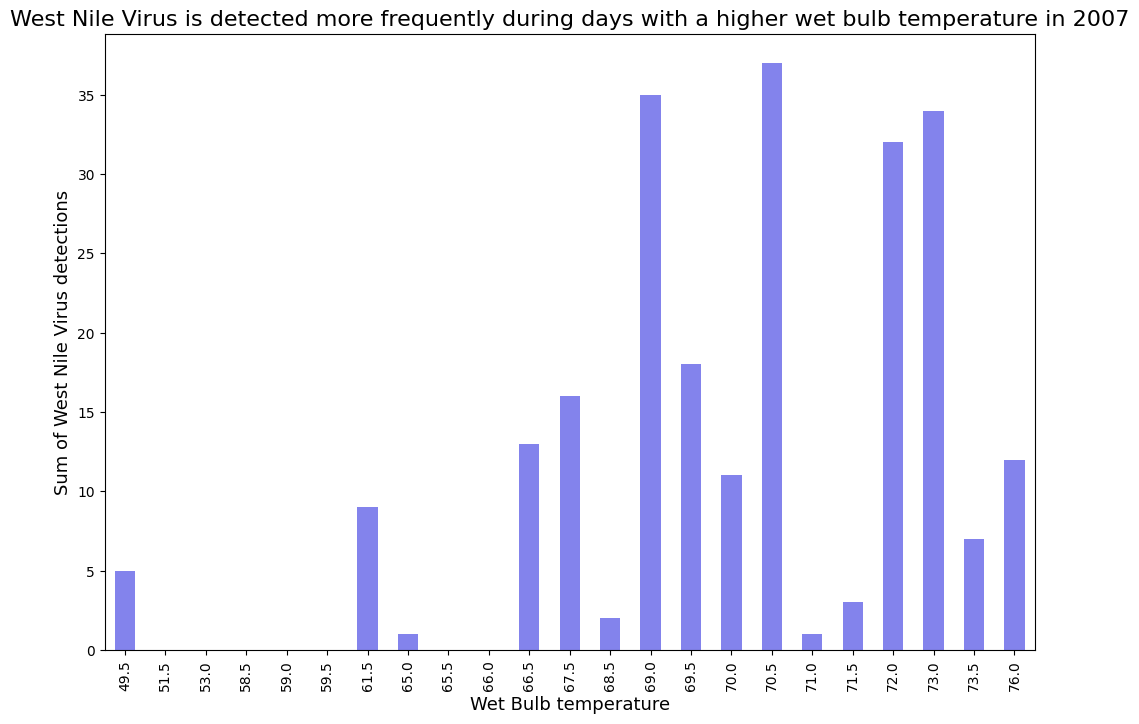

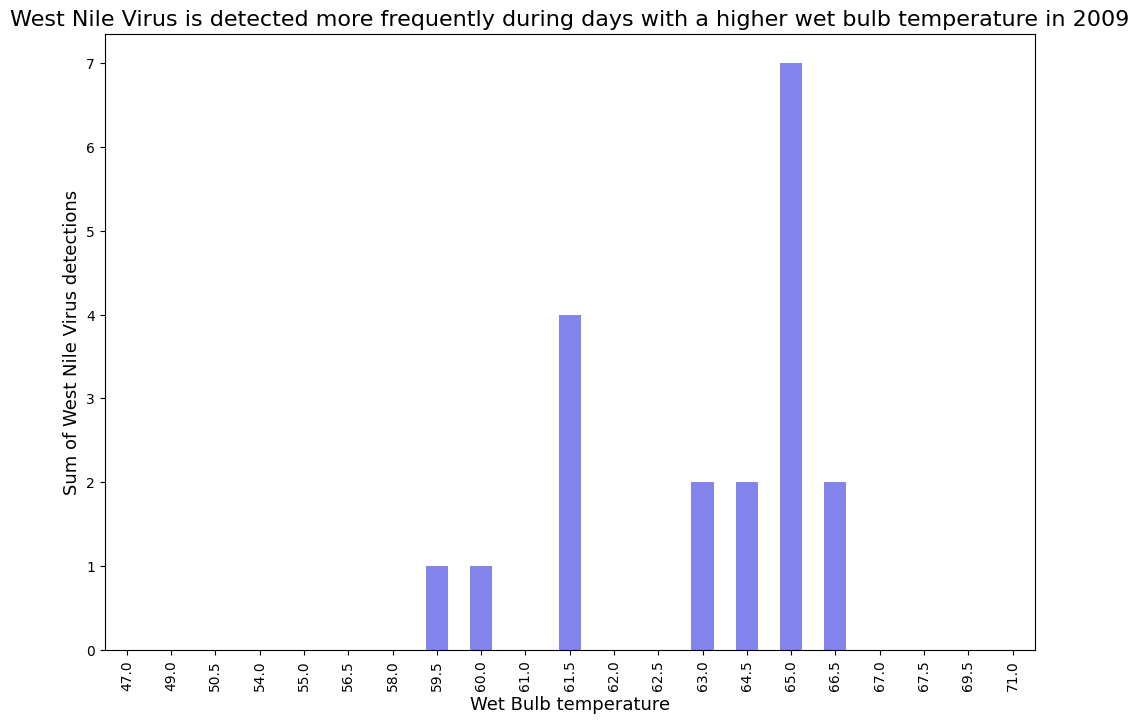

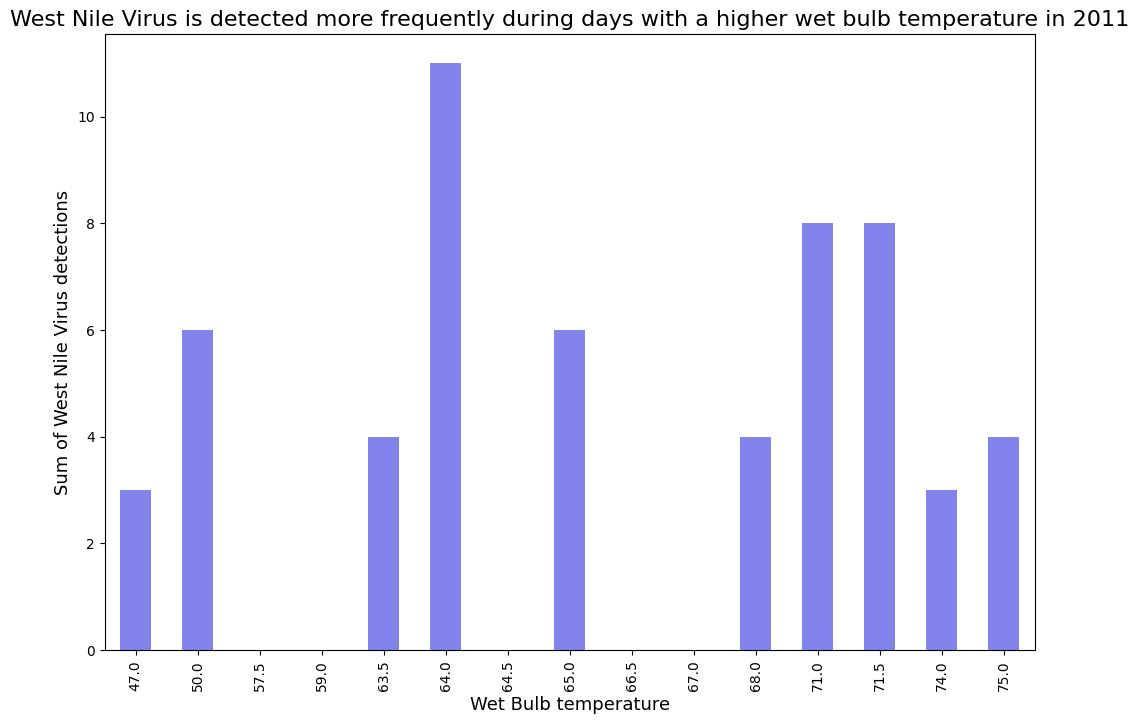

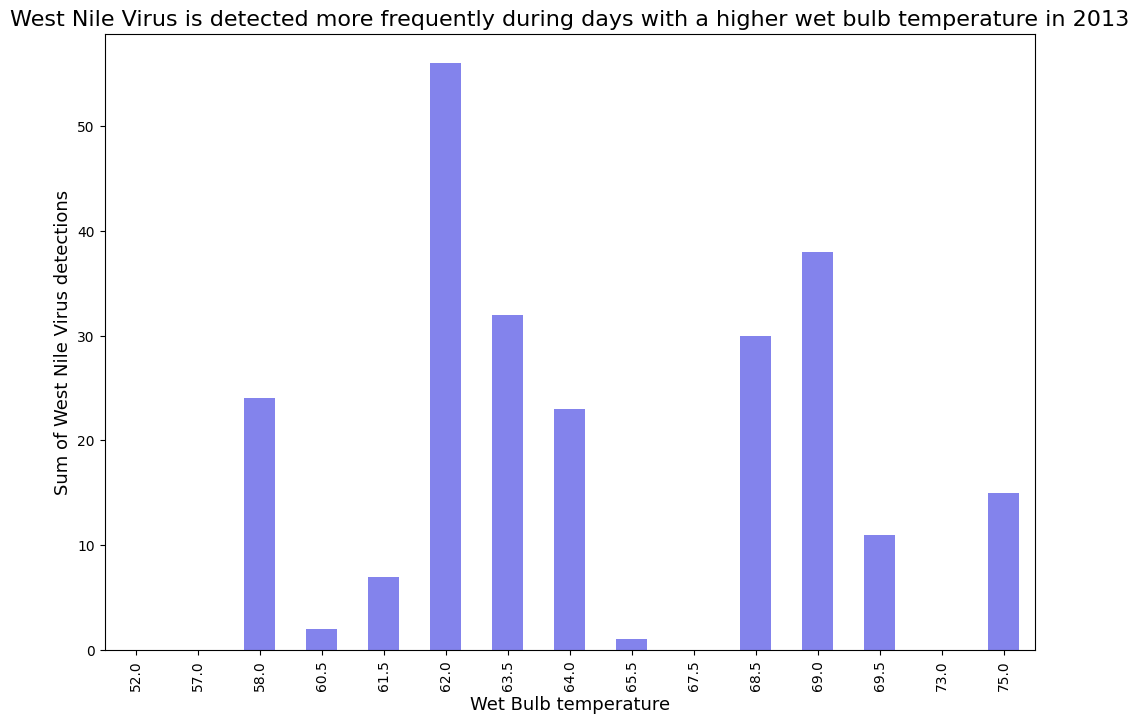

In [28]:
for x in merged_df['Year'].unique():
    plt.figure(figsize=(12,8))
    merged_df[merged_df['Year']==x].groupby(['WetBulb'])['WnvPresent'].sum().plot.bar(color='#8383EC') 
    plt.title(f"West Nile Virus is detected more frequently during days with a higher wet bulb temperature in {x}", fontsize=16)
    plt.xlabel("Wet Bulb temperature", fontsize =13)
    plt.xticks(rotation=90)
    plt.ylabel("Sum of West Nile Virus detections", fontsize=13)

When we look at the relationship between wet bulb temperature/ dew point temperature vs WNV present individually, we can see that there is a range showing that the WNV detected:
- wet bulb temperature - between 50° to 76° Fahrenheit
- dew point temperature - between 55° to 70° Fahrenheit

### Temperatures

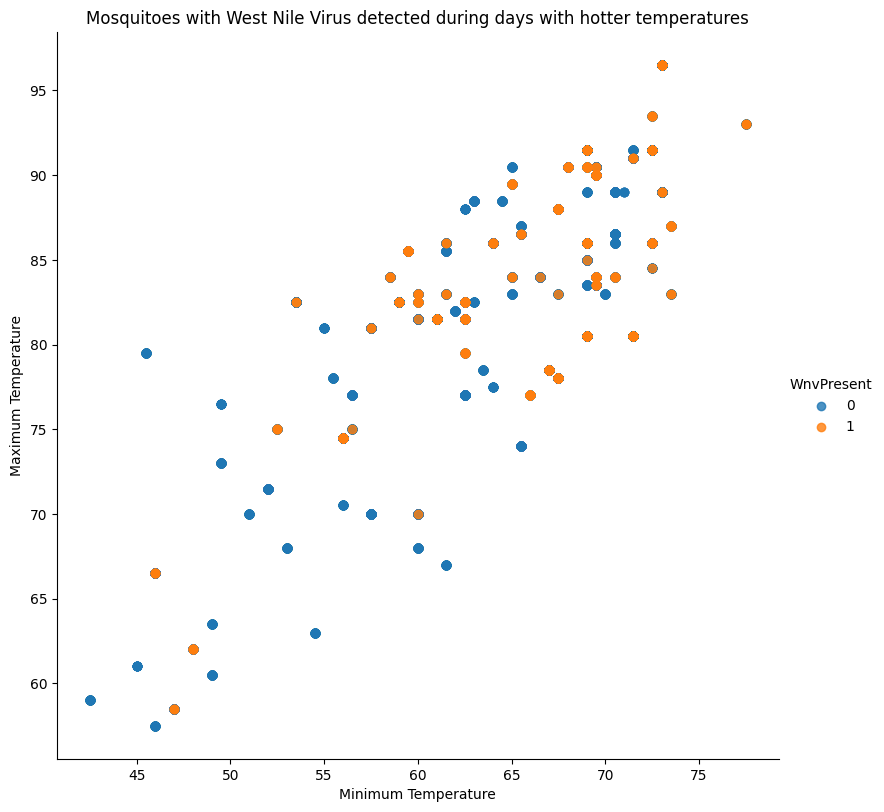

In [29]:
sns.lmplot( x='Tmin', y='Tmax', data=merged_df, fit_reg=False, hue='WnvPresent', height=8)
plt.title('Mosquitoes with West Nile Virus detected during days with hotter temperatures')
plt.xlabel('Minimum Temperature')
plt.ylabel('Maximum Temperature');

It's well known that mosquitoes love warm climates. From the scatter plot, we can see that most of the WVN cases happened when the days with the temperature above 50° Fahrenheit.

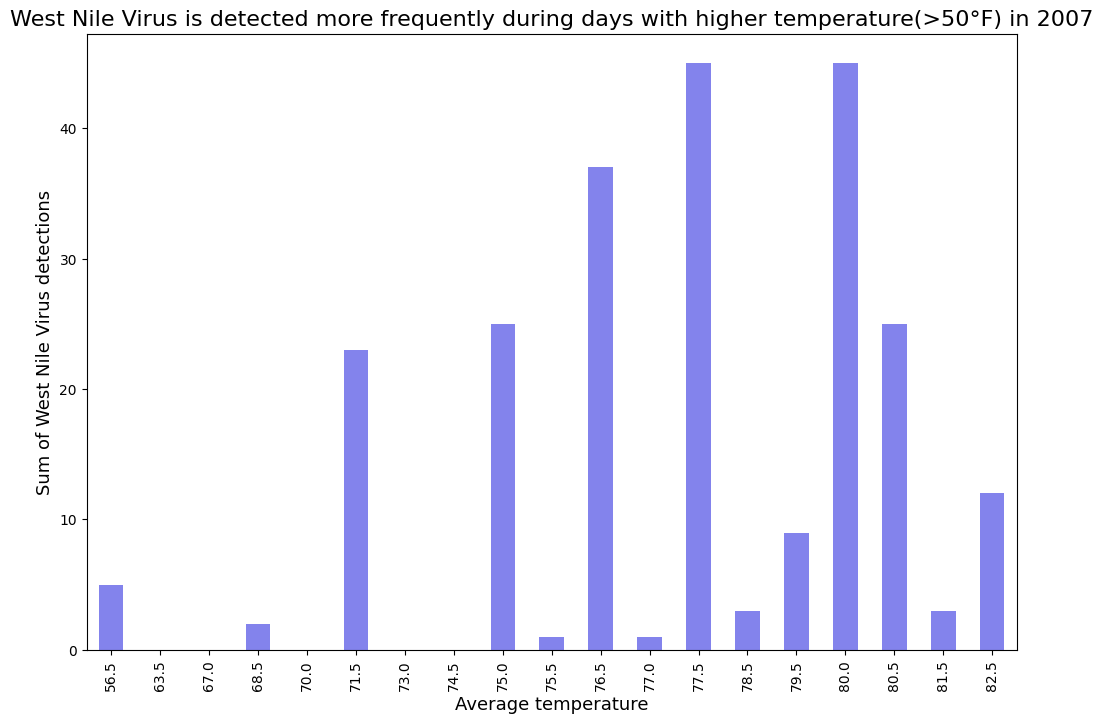

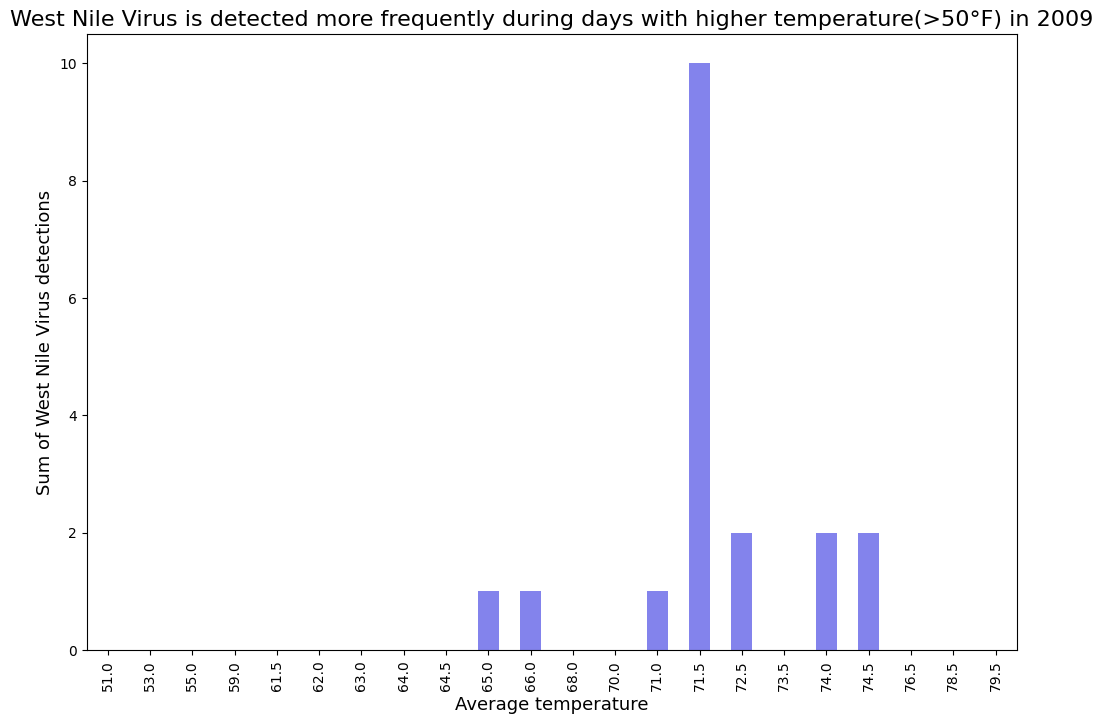

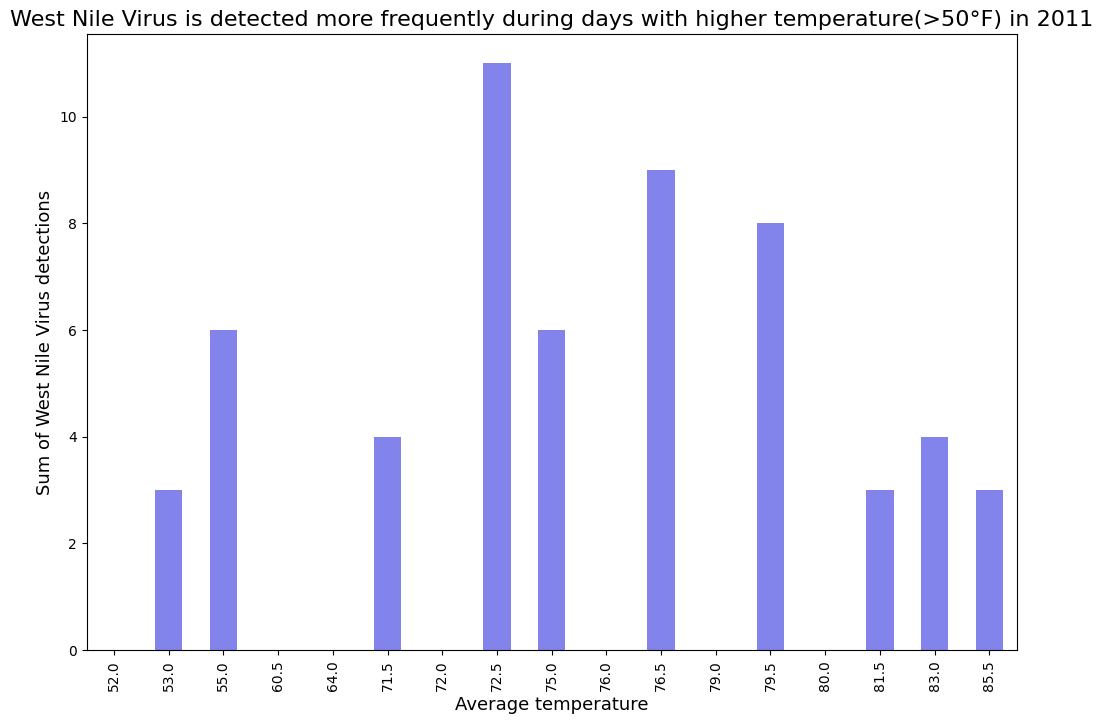

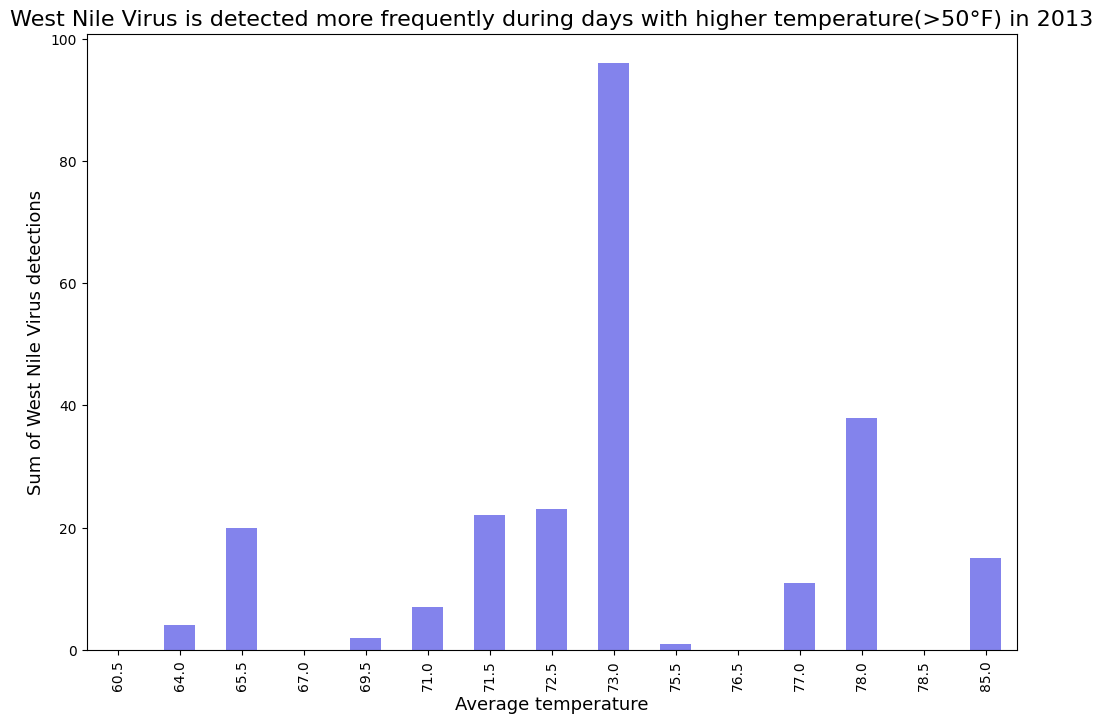

In [30]:
for x in merged_df['Year'].unique():
    plt.figure(figsize=(12,8))
    merged_df[merged_df['Year']==x].groupby(['Tavg'])['WnvPresent'].sum().plot.bar(color='#8383EC') 
    plt.title(f"West Nile Virus is detected more frequently during days with higher temperature(>50°F) in {x}", fontsize=16)
    plt.xlabel("Average temperature", fontsize =13)
    plt.xticks(rotation=90)
    plt.ylabel("Sum of West Nile Virus detections", fontsize=13)

### Analysing Spray Efficacy

Our spray dataset from the get-go is pretty limited in terms of usefulness as we only have two years in which spraying occured. In 2011, there were two days in which spraying was carried out. In 2013, spraying was much more extensive, and was carried out on 7 different days. Generally it seems that spraying doesn't have an observable effect on WnvPresent -- it would likely take larvacide instead of something like Zenivex, which is a mosquito adulticide.

In [31]:
spray['Year'] = pd.to_datetime(spray['Date']).apply(lambda x: x.year)
spray['Week'] = pd.to_datetime(spray['Date']).apply(lambda x: x.week)
merged_df = pd.merge(weather, train, on=['Date', 'Year', 'Week', 'Month', 'DayOfWeek'])
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

In [32]:
def target_plot(target, color):
    for year in [2011, 2013]:
        fig, ax1 = plt.subplots(figsize=(10,4))
        temp_df = merged_df[merged_df['Year']==year].groupby(['Week'])[target].sum().to_frame()

        sns.lineplot(x=temp_df.index, y=temp_df[target],
                     ci=None, color=color, label=f'{target}', ax=ax1)
        ax1.set_ylabel(f'{target}', fontsize=13)
        ax1.legend(loc=1)
        
        if year in spray['Year'].unique():
            for date in spray[spray['Year'] == year].groupby('Week').mean().index:
                plt.axvline(date, linestyle='--', color='black', alpha=0.5, label='Spray')
        
        plt.legend([f'{target}', 'Spray'])
        plt.title(f'{target} in {year}')
        plt.tight_layout()

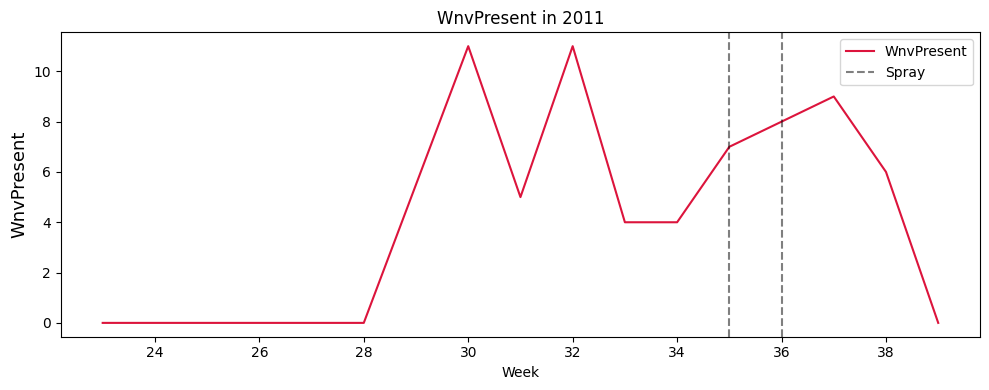

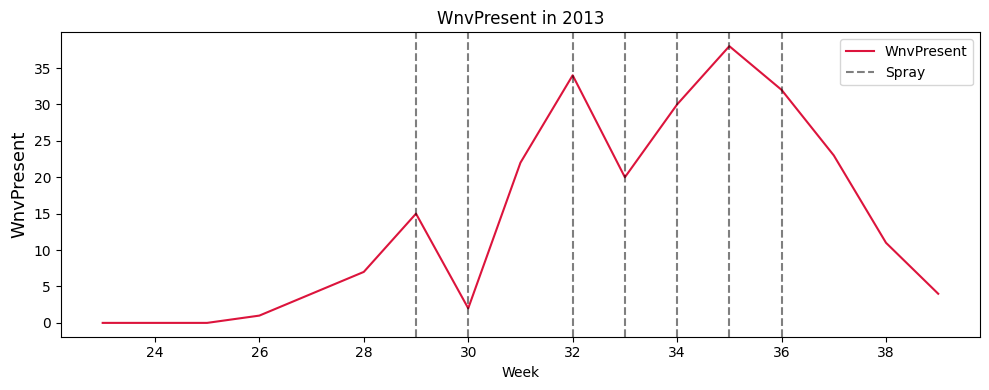

In [33]:
# Spraying don't seem to have a clear/immediate effect on WNV found within traps
target_plot('WnvPresent', 'crimson')

It's hard to fully gauge the effects of the spraying based on our current data, but it seems that the spraying is helping to keep the mosquito population in control.

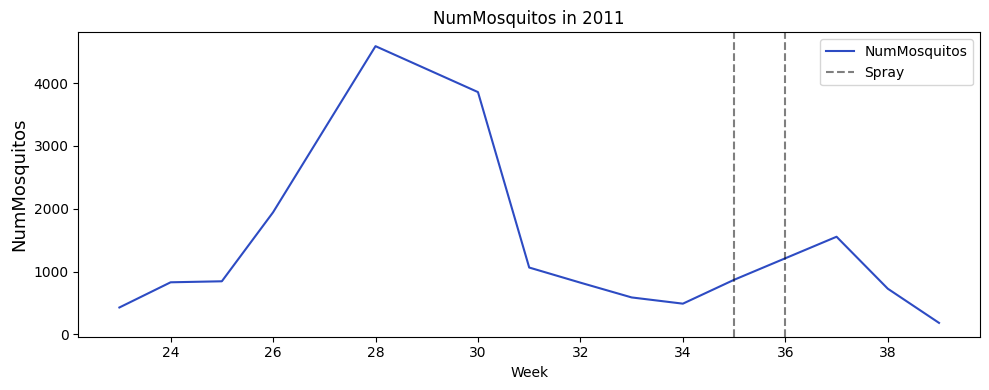

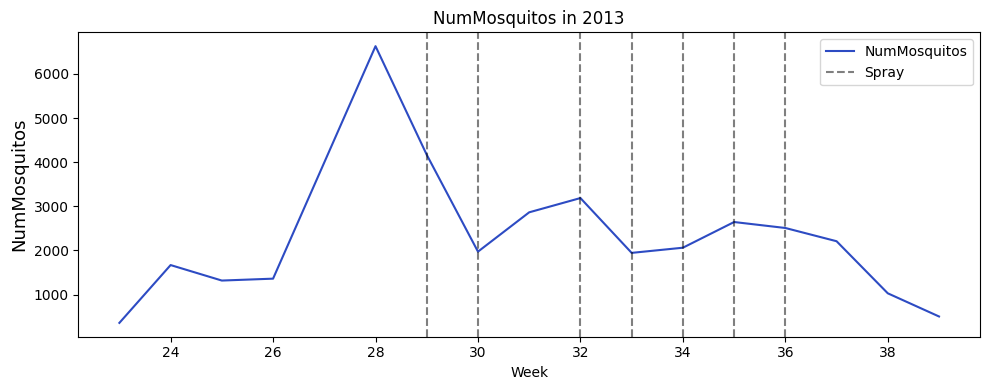

In [34]:
# These sprays seem to have a limited effect on number of mosquitos found in traps
target_plot('NumMosquitos', '#2d4bc3')

## Summary
Based on the exploratory data analysis, we noted that not all mosquito species carry WNV. The two main vectors of WNV are CULEX PIPENS and CULEX RESTUANS, they contributed to 99.5% of the mosquitos captured in the traps. Summer is the season whereby WNV occurrences increase, starting from June, and peaks in August before declining slightly in September. While traps have been placed across Chicago, not all hotspots where WNV outbreaks occur have traps set up thoroughly. There is only spray information recorded in 2011 and 2013. The information shows that the spray area fails to fully overlap with the virus outbreak hotspots, indicating the cause for concern as a result of improper spray coverage. 

## Next Steps
In the next notebook, we'll look into feature engineering, and the various preprocessing steps (eg. feature selection & one-hot encoding) to prepare our data for modeling.